In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import requests
from bs4 import BeautifulSoup
import time
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
receipts_df = pd.read_csv("20241111_export_pharmacy_receiptdata_receipt.csv", dtype=str) 
lineitems_df = pd.read_csv("20241111_export_pharmacy_receiptdata_lineitem.csv", dtype={'amount': float, 'quantity': int, 'transaction_id': str, 'pzn': str})
products_df = pd.read_csv("20241114_export_pharmacy_receiptdata_products.csv", header=None, names=['pzn', 'name'], dtype=str)

# types of the columns
print(receipts_df.dtypes)
print(lineitems_df.dtypes)
print(products_df.dtypes)

transaction_id    object
retailer_id       object
gln               object
zipcode_area      object
pos_id            object
timestamp         object
dtype: object
transaction_id     object
pzn                object
amount            float64
quantity            int32
dtype: object
pzn     object
name    object
dtype: object


In [3]:
# Rename the column 'gtin' to 'pzn'
products_df.rename(columns={'gtin': 'pzn'}, inplace=True)

## Part 1: find any errors, missing data or duplicates

In [4]:
# Convert 'timestamp' to datetime for easier handling
receipts_df['timestamp'] = pd.to_datetime(receipts_df['timestamp'])

# Convert 'amount' from euro cents to euros -> note from the professor: "amount" is in euro cents
lineitems_df['amount'] = lineitems_df['amount'] / 100

In [5]:
# Check for duplicates in receipts
duplicates_receipts = receipts_df[receipts_df.duplicated()]
print(f"Duplicate receipts: {len(duplicates_receipts)}")

# Check for duplicates in line items
duplicates_lineitems = lineitems_df[lineitems_df.duplicated()]
print(f"Duplicate line items: {len(duplicates_lineitems)}")

Duplicate receipts: 0
Duplicate line items: 3465


In [6]:
# Drop duplicates
receipts_df.drop_duplicates(inplace=True)
lineitems_df.drop_duplicates(inplace=True)

In [7]:
# Check for negative prices
negative_prices = lineitems_df[lineitems_df['amount'] < 0]
print(f"Negative price entries: {len(negative_prices)}")

Negative price entries: 0


In [8]:
# Check for unrealistically high prices
high_prices = lineitems_df[lineitems_df['amount'] > 1000]
print(f"Unrealistically high price entries (amount > 1000): {len(high_prices)}")

Unrealistically high price entries (amount > 1000): 3


In [9]:
# check for very large amounts 
large_amounts = lineitems_df[lineitems_df['quantity'] > 100]
print(f"Unrealistically large quantity (quantity> 100): {len(large_amounts)}")

Unrealistically large quantity (quantity> 100): 7


In [10]:
print(f"quantity (> 100): {len(large_amounts)}")

# check for 90 - 100 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 90) & (lineitems_df['quantity'] <= 100)]
print(f"quantity (90 - 100): {len(large_amounts)}")

# check for 70 - 90 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 70) & (lineitems_df['quantity'] < 90)]
print(f"quantity (70 - 90): {len(large_amounts)}")

# check for 50 - 70 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 50) & (lineitems_df['quantity'] < 70)]
print(f"quantity (50 - 70): {len(large_amounts)}")

# check for 30 - 50 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 30) & (lineitems_df['quantity'] < 50)]
print(f"quantity (30 - 50): {len(large_amounts)}")

# check for 10 - 30 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 10) & (lineitems_df['quantity'] < 30)]
print(f"quantity (10 - 30): {len(large_amounts)}")

# check for 1 - 10 amounts
large_amounts = lineitems_df[(lineitems_df['quantity'] >= 1) & (lineitems_df['quantity'] < 10)]
print(f"quantity (1 - 10): {len(large_amounts)}")

# check for 0 - 1 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] == 0]
print(f" quantity (0): {len(large_amounts)}")

# check for < 0 amounts
large_amounts = lineitems_df[lineitems_df['quantity'] < 0]
print(f"quantity (< 0): {len(large_amounts)}")

quantity (> 100): 7
quantity (90 - 100): 7
quantity (70 - 90): 2
quantity (50 - 70): 25
quantity (30 - 50): 48
quantity (10 - 30): 1379
quantity (1 - 10): 3332728
 quantity (0): 0
quantity (< 0): 0


In [11]:
# delete line item with zero or negative amount
lineitems_df = lineitems_df[lineitems_df['amount'] > 0]

In [12]:
# Convert 'zipcode_area' to string
receipts_df['zipcode_area'] = receipts_df['zipcode_area'].astype(str)

codes = {}
# Find zip codes with different lengths
for length in range(1, 6):
    zipcodes = receipts_df[receipts_df['zipcode_area'].str.match(r'^\d{' + str(length) + '}$')]
    codes[length] = zipcodes
    print(f"{length}-digit zip codes: {len(zipcodes)}")
    print(zipcodes['zipcode_area'].unique()[:5])

# check for any bad zip codes that are not digits (1 - 5 digits)
bad_zipcodes = receipts_df[~receipts_df['zipcode_area'].str.match(r'^\d{1,5}$')]
print(f"Bad zip codes (not 1-5 digits): {len(bad_zipcodes)}")

1-digit zip codes: 0
[]
2-digit zip codes: 0
[]
3-digit zip codes: 1752183
['537' '355' '459' '508' '073']
4-digit zip codes: 0
[]
5-digit zip codes: 0
[]
Bad zip codes (not 1-5 digits): 0


In [13]:
# Handle Missing Entries
print(receipts_df.isnull().sum())
print('-' * 80)
print(lineitems_df.isnull().sum())
print('-' * 80)
print(products_df.isnull().sum())

transaction_id    0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
dtype: int64
--------------------------------------------------------------------------------
transaction_id    0
pzn               0
amount            0
quantity          0
dtype: int64
--------------------------------------------------------------------------------
pzn     0
name    0
dtype: int64


- <mark>The prof mail says "Approx 12000 pzn are still missing in the product file" (confirmed)</mark>

In [14]:
# number of unique pnz in lineitems_df
print(f"Number of unique pzn in lineitems_df: {len(lineitems_df['pzn'].unique())}")
# number of unique pnz in products_df
print(f"Number of unique pzn in products_df: {len(products_df['pzn'].unique())}")

#  diff
diff = set(lineitems_df['pzn'].unique()) - set(products_df['pzn'].unique())
print(f"Number of unique pzn in lineitems_df but not in products_df: {len(diff)}")

Number of unique pzn in lineitems_df: 39832
Number of unique pzn in products_df: 44771
Number of unique pzn in lineitems_df but not in products_df: 8776


#### Data Merging and Integration

In [15]:
# Merge data
product_and_lineitems_df = lineitems_df.merge(products_df, on='pzn', how='inner')

print(f"Total number of line items in lineitems_df: {len(lineitems_df)}")
print(f"Total number of line items after merging with products: {len(product_and_lineitems_df)}")
print(f"Number of line items dropped during merge: {len(lineitems_df) - len(product_and_lineitems_df)}")


Total number of line items in lineitems_df: 3323093
Total number of line items after merging with products: 3289752
Number of line items dropped during merge: 33341


In [16]:
full_df = product_and_lineitems_df.merge(receipts_df, on='transaction_id', how='inner')

In [17]:
print(full_df.isnull().sum())

transaction_id    0
pzn               0
amount            0
quantity          0
name              0
retailer_id       0
gln               0
zipcode_area      0
pos_id            0
timestamp         0
dtype: int64


In [18]:
print("orignal number for line items: ", len(lineitems_df))
print("number after merge: ", len(product_and_lineitems_df))
print("number of line items that are missing the name in the products or the receipt (removed after the merge): ", len(lineitems_df) - len(product_and_lineitems_df))

orignal number for line items:  3323093
number after merge:  3289752
number of line items that are missing the name in the products or the receipt (removed after the merge):  33341


## Campaign products: 
### How do the price of some selected products (e.g. Eucerin brand) changes over time? See the Acardo report for a campaign pzn

- The promotional campaign run by Beiersdorf for the product line "Eucerin" from  1/12/2023, to 29/2/2024

In [19]:
# 1. get only the line in the date range of the campaign (1/12/2023, to 29/2/2024)
campaign_start = datetime(2023, 12, 1)
campaign_end = datetime(2024, 2, 29)
campaign_df = full_df[(full_df['timestamp'] >= campaign_start) & (full_df['timestamp'] <= campaign_end)]

print(f"totla count", len(full_df))
print(f"campaign count", len(campaign_df))
print(f"campaign percentage", len(campaign_df) / len(full_df))


totla count 3292184
campaign count 448585
campaign percentage 0.13625757248076048


In [20]:
# 2. get only products that are from the brand "Eucerin"
eucerin_campaign_df = campaign_df[campaign_df['name'].str.contains('Eucerin', case=False, na=False)]
print(f"Number of Eucerin products: {len(eucerin_campaign_df)}")
print(f"Percentage of Eucerin products: {len(eucerin_campaign_df) / len(campaign_df)}")
print(eucerin_campaign_df.head(10))

Number of Eucerin products: 290833
Percentage of Eucerin products: 0.648334206449168
                           transaction_id       pzn  amount  quantity  \
74   c3386b37-4cf7-492d-bccb-000000622420  11678142   22.45         1   
275  706658f5-c3d2-4c1d-96e6-000000552174  15389771   14.07         1   
276  706658f5-c3d2-4c1d-96e6-000000552174  13889133   19.67         1   
333  ac435ed5-bb2c-4ce4-b52a-000000635836  13929074   32.66         1   
360  334a12d3-30f7-43d3-ba63-000000691208  17510751   33.50         1   
361  334a12d3-30f7-43d3-ba63-000000691208  16143121   15.90         1   
525  274be37c-fdf3-476f-97bc-000000202570  10268672   22.95         1   
546  58926b06-322b-4ec6-9f92-000000282296  08796286    7.27         1   
550  58926b06-322b-4ec6-9f92-000000282296  16901337   16.48         1   
583  88fc14fe-0006-4304-b661-000000656036  13167925   32.95         1   

                           name retailer_id      gln zipcode_area pos_id  \
74    EUCERIN UREAREP PL LOT10%    

In [21]:
# 3. get non-Eucerin products
non_promotional_items_df = campaign_df[~campaign_df['name'].str.contains('Eucerin', case=False, na=False)]

In [22]:
# Top 20 products by revenue
products = eucerin_campaign_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(20)

#  get the average price for the top 20 products
# calc: total amount / total quantity
rseults = []
for pzn in products.index:
    product = {"pzn": pzn, "name": products_df[products_df['pzn'] == pzn]['name'].values[0]}
    total_amount = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['amount'].sum()
    total_quantity = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['quantity'].sum()
    average_price = total_amount / total_quantity
    product['average_price'] = average_price

    #  number of items sold
    product['number_of_items_sold'] = total_quantity

    # number of receipts
    product['number_of_receipts'] = eucerin_campaign_df[eucerin_campaign_df['pzn'] == pzn]['transaction_id'].nunique()

    rseults.append(product)

# write the top 20 products to a csv file
rseults = pd.DataFrame(rseults)
# number should only 2 decimal points
rseults['average_price'] = rseults['average_price'].round(2)
rseults.to_csv('top_20_products.csv', index=False)

# validation

#pzn_from_report = ['11678159','11652964','04668723','16154610','08454746','08454700','11652958','18222089','13929074','07608420','15581586','15294332','14163898','11678142','13167925','11678001','14163929','12441459','11678047','11678099']


In [23]:
# Top 20 products by revenue
# Step 1: Group by 'pzn' and calculate the sum of 'amount'
top_pzn = eucerin_campaign_df.groupby('pzn', as_index=False)['amount'].sum()

# Step 2: Get the top 5 'pzn' values based on the 'amount'
top_5_pzn = top_pzn.nlargest(5, 'amount')['pzn']

# Print the result
print(top_5_pzn)

51     11652964
63     11678159
125    16154610
13     04668723
158    18222089
Name: pzn, dtype: object


# Price Trends during campaign period

C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


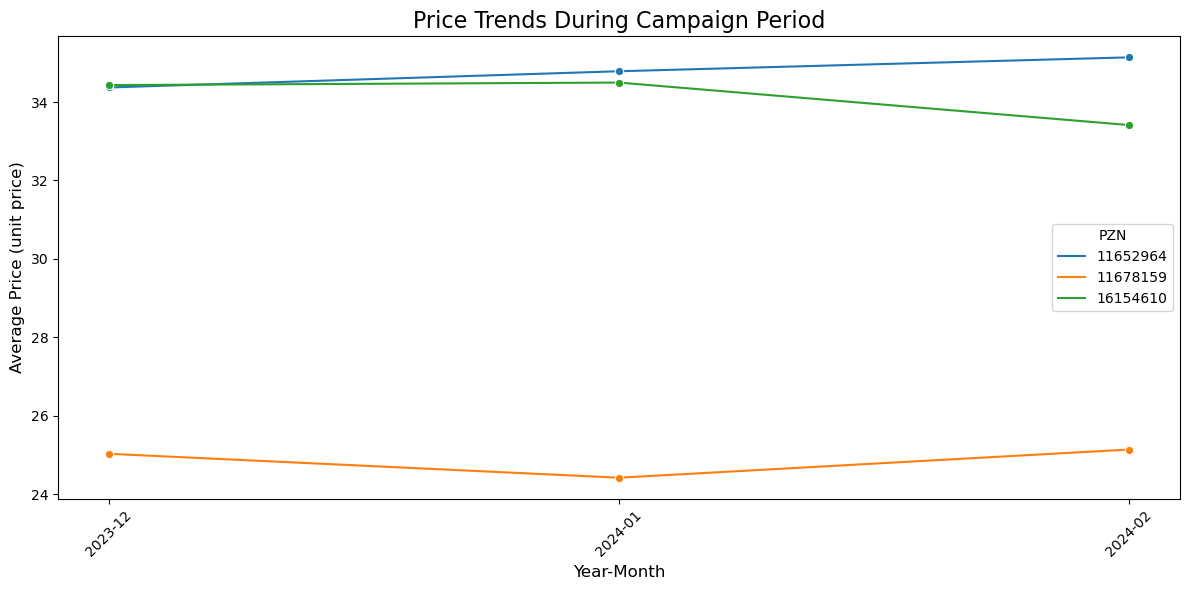

C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


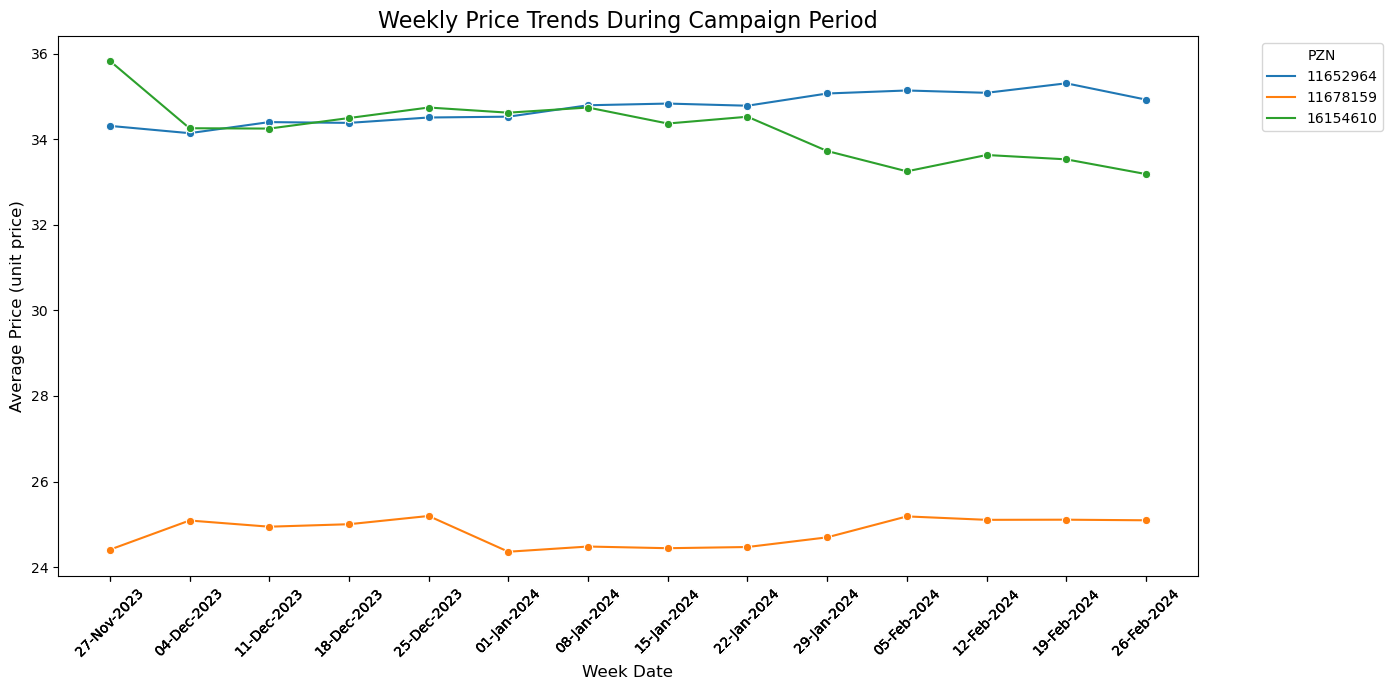

In [24]:
# Load the dataset
data_campaign_period = campaign_df

# Filter for the required PZN (e.g., 11652964 and 04668723)
# selected_pzn = ['11652964','11678159', '16154610', '04668723', '18222089']
selected_pzn = ['11652964','11678159', '16154610']
campaign_products3_campaign_period = data_campaign_period[data_campaign_period['pzn'].isin(selected_pzn)]

#calculate unit price
campaign_products3_campaign_period['unit_price'] = campaign_products3_campaign_period['amount'] / campaign_products3_campaign_period['quantity']

# Convert timestamp to datetime
campaign_products3_campaign_period['timestamp'] = pd.to_datetime(campaign_products3_campaign_period['timestamp'])

#monthly data
campaign_products3_campaign_period_monthly = campaign_products3_campaign_period
# Extract year and month for grouping
campaign_products3_campaign_period_monthly['year_month'] = campaign_products3_campaign_period_monthly['timestamp'].dt.to_period('M')

# Calculate average price over time for each PZN
price_trends = campaign_products3_campaign_period_monthly.groupby(['pzn', 'year_month']).agg({'unit_price': 'mean'}).reset_index()
price_trends['year_month'] = price_trends['year_month'].astype(str)

# Plot price trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trends, x='year_month', y='unit_price', hue='pzn', marker='o')
plt.title('Price Trends During Campaign Period', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='PZN')
plt.tight_layout()
plt.show()

#daily data
campaign_products_campaign_period_weekly = data_campaign_period[data_campaign_period['pzn'].isin(selected_pzn)]
#calculate unit price
campaign_products_campaign_period_weekly['unit_price'] = campaign_products_campaign_period_weekly['amount'] / campaign_products_campaign_period_weekly['quantity']

# Add a column for the week start date (Monday of each week)
campaign_products_campaign_period_weekly['week_start'] = campaign_products_campaign_period_weekly['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate average price over time for each PZN (weekly)
weekly_price_trends = campaign_products_campaign_period_weekly.groupby(['pzn', 'week_start']).agg({'unit_price': 'mean'}).reset_index()

# Plot weekly price trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=weekly_price_trends, x='week_start', y='unit_price', hue='pzn', marker='o')

# Customize the plot
plt.title('Weekly Price Trends During Campaign Period', fontsize=16)
plt.xlabel('Week Date', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)

# Format x-axis to display each week's date (e.g., Monday of each week)
plt.xticks(weekly_price_trends['week_start'], 
           labels=weekly_price_trends['week_start'].dt.strftime('%d-%b-%Y'), 
           rotation=45)

plt.legend(title='PZN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

# Overall Price trends of campaign products

C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


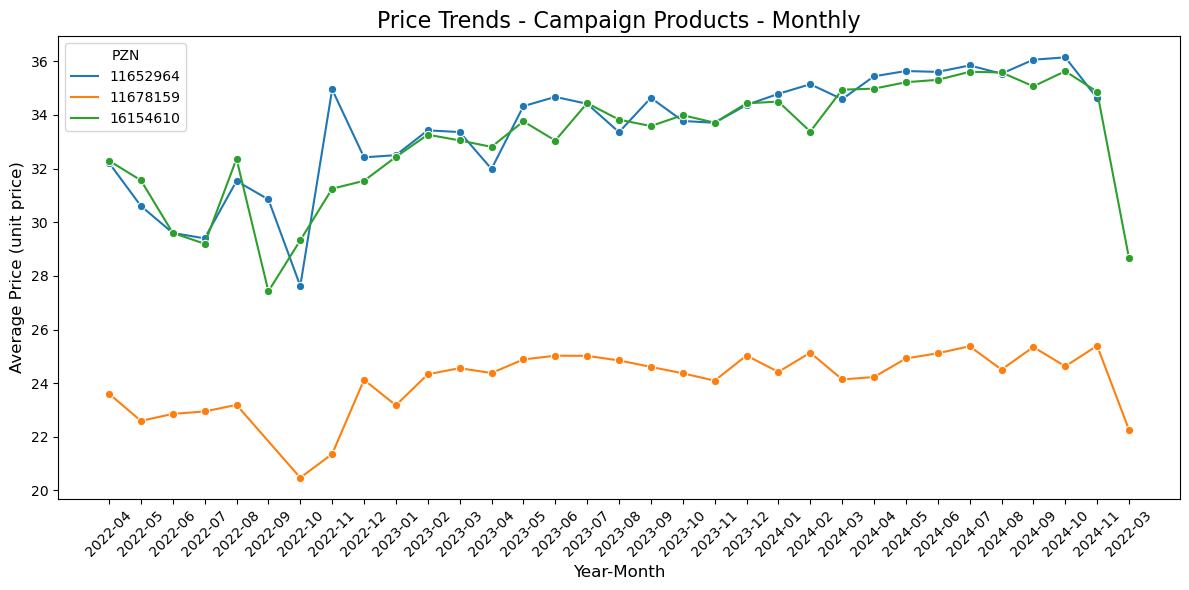

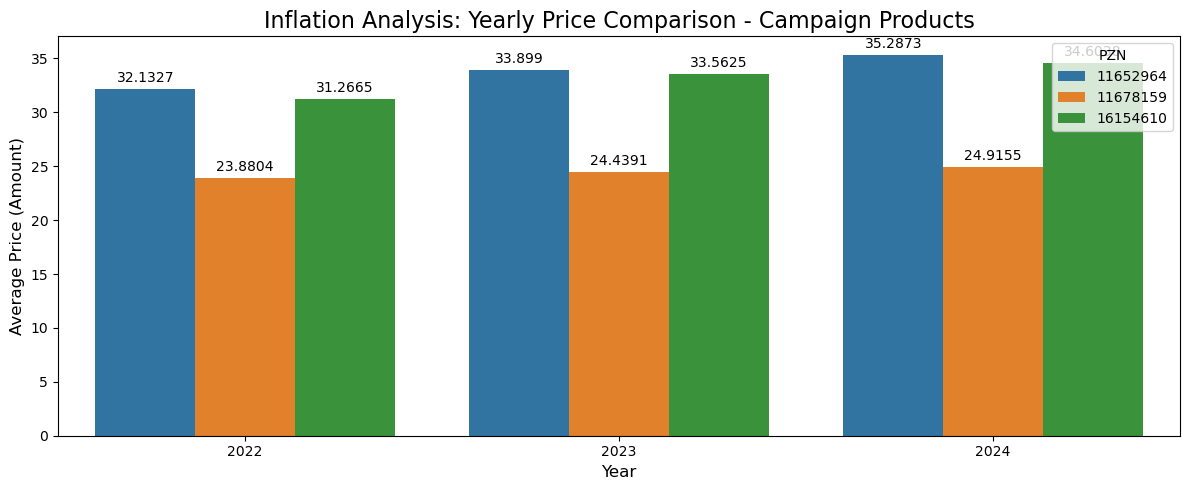

C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\josea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


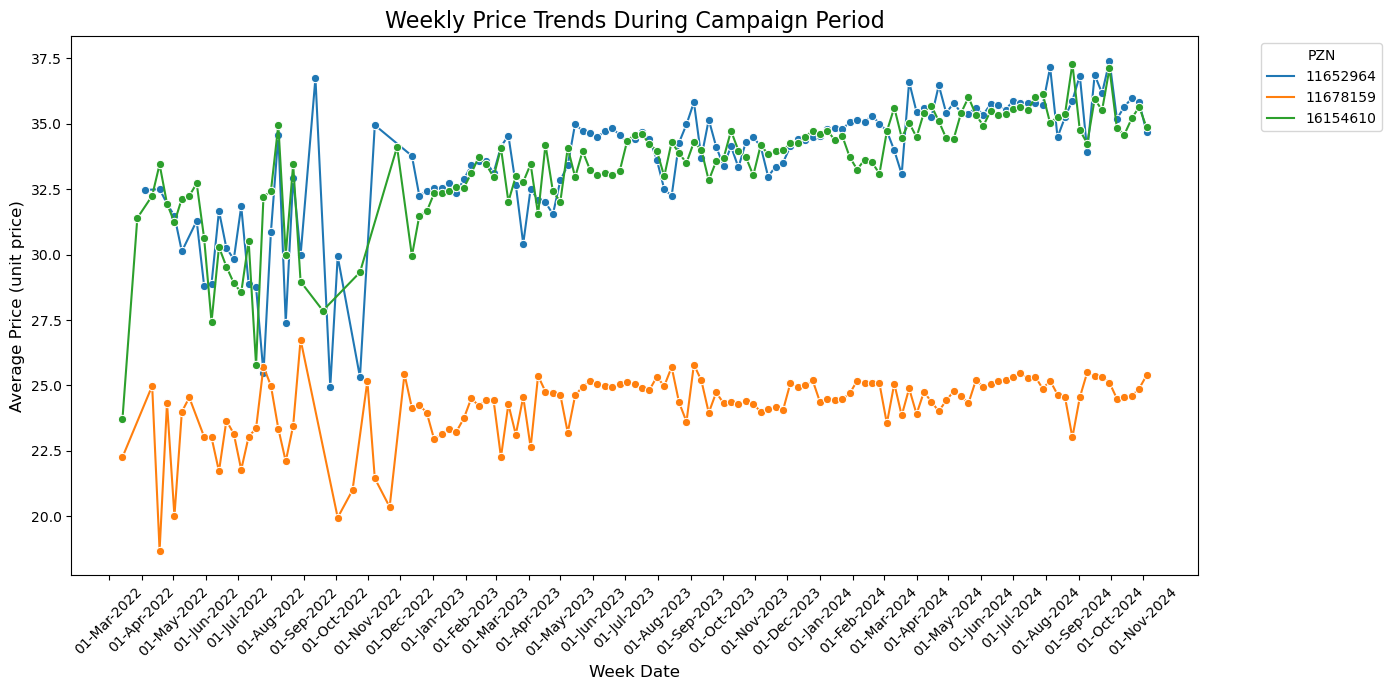

In [25]:
# Filter for the required PZN (e.g., 11652964 and 04668723)
# selected_pzn = ['11652964','11678159', '16154610', '04668723', '18222089']
selected_pzn = ['11652964','11678159', '16154610']
campaign_products3_full_period = full_df[full_df['pzn'].isin(selected_pzn)]

#calculate unit price
campaign_products3_full_period['unit_price'] = campaign_products3_full_period['amount'] / campaign_products3_full_period['quantity']

# Convert timestamp to datetime
campaign_products3_full_period['timestamp'] = pd.to_datetime(campaign_products3_full_period['timestamp'])

# Extract year and month for grouping
campaign_products3_full_period['year_month'] = campaign_products3_full_period['timestamp'].dt.to_period('M')

# Calculate average price over time for each PZN
price_trends = campaign_products3_full_period.groupby(['pzn', 'year_month']).agg({'unit_price': 'mean'}).reset_index()
price_trends['year_month'] = price_trends['year_month'].astype(str)

# Plot price trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trends, x='year_month', y='unit_price', hue='pzn', marker='o')
plt.title('Price Trends - Campaign Products - Monthly', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='PZN')
plt.tight_layout()
plt.show()


# Calculate average price over time for each PZN
campaign_products3_full_period['year'] = campaign_products3_full_period['timestamp'].dt.year
yearly_prices = campaign_products3_full_period.groupby(['pzn', 'year']).agg({'unit_price': 'mean'}).reset_index()

# Plot yearly price inflation
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=yearly_prices, x='year', y='unit_price', hue='pzn')

# Add the value above each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=3)

# Title and labels
plt.title('Inflation Analysis: Yearly Price Comparison - Campaign Products', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price (Amount)', fontsize=12)
plt.legend(title='PZN')
plt.tight_layout()
plt.show()


#daily data
campaign_products_full_period_weekly = campaign_products3_full_period
#calculate unit price
campaign_products_full_period_weekly['unit_price'] = campaign_products_full_period_weekly['amount'] / campaign_products_full_period_weekly['quantity']

# Add a column for the week start date (Monday of each week)
campaign_products_full_period_weekly['week_start'] = campaign_products_full_period_weekly['timestamp'].dt.to_period('W').apply(lambda r: r.start_time)

# Calculate average price over time for each PZN (weekly)
weekly_price_trends = campaign_products_full_period_weekly.groupby(['pzn', 'week_start']).agg({'unit_price': 'mean'}).reset_index()

# Plot weekly price trends
plt.figure(figsize=(14, 7))
sns.lineplot(data=weekly_price_trends, x='week_start', y='unit_price', hue='pzn', marker='o')

# Customize the plot
plt.title('Weekly Price Trends During Campaign Period', fontsize=16)
plt.xlabel('Week Date', fontsize=12)
plt.ylabel('Average Price (unit price)', fontsize=12)

# Get the first date of each month
monthly_start_dates = weekly_price_trends['week_start'].dt.to_period('M').dt.start_time.drop_duplicates()

# Set the x-ticks to the monthly start dates
plt.xticks(monthly_start_dates, 
           labels=monthly_start_dates.dt.strftime('%d-%b-%Y'), 
           rotation=45)

plt.legend(title='PZN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

# Turnover analysis for all campaign products over whole period

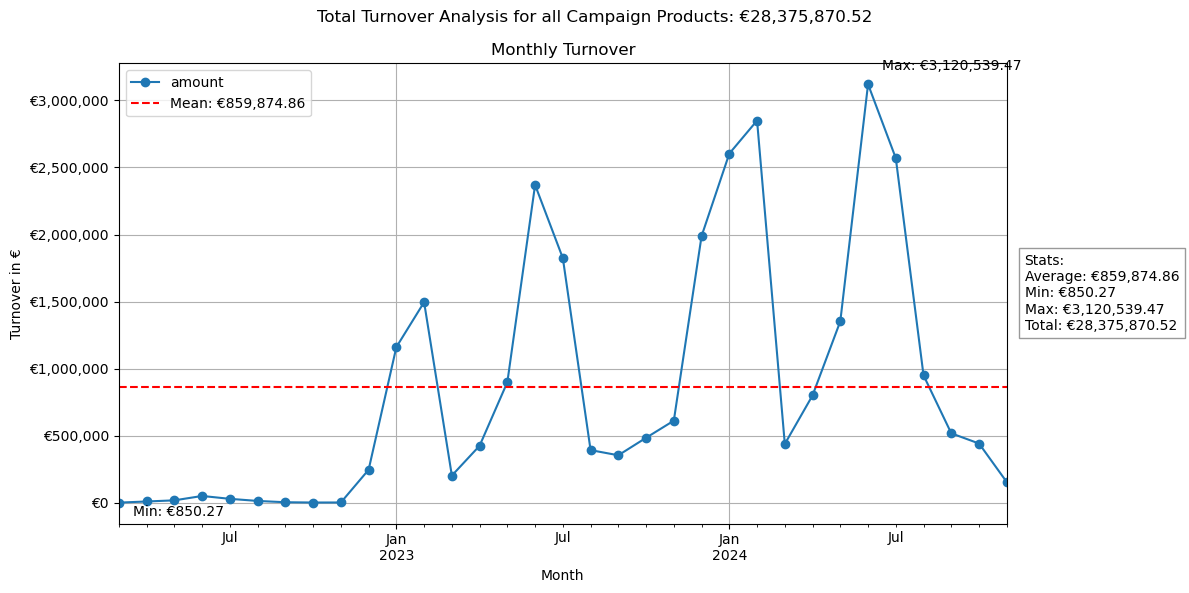

In [26]:
def analyze_turnover(df):
    total_turnover = df['amount'].sum()
    
    # Analyzing monthly turnover
    monthly_turnover = df.groupby(df['timestamp'].dt.to_period('M'))['amount'].sum()

    # Create the figure and axis for a single graph
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Total Turnover Analysis for all Campaign Products: €{total_turnover:,.2f}')
    
    # Plot the data
    monthly_turnover.plot(ax=ax, marker='o')
    ax.set_title('Monthly Turnover')
    ax.set_ylabel('Turnover in €')
    ax.set_xlabel('Month')
    
    # Add a mean line
    mean_val = monthly_turnover.mean()
    ax.axhline(y=mean_val, color='red', linestyle='--', label=f'Mean: €{mean_val:,.2f}')
    
    # Add max/min annotations
    max_val = monthly_turnover.max()
    min_val = monthly_turnover.min()
    ax.annotate(f'Max: €{max_val:,.2f}', 
                xy=(monthly_turnover.idxmax(), max_val),
                xytext=(10, 10), 
                textcoords='offset points')
    ax.annotate(f'Min: €{min_val:,.2f}',
                xy=(monthly_turnover.idxmin(), min_val),
                xytext=(10, -10),
                textcoords='offset points')
    
    # Add a stats box
    stats_text = (
        f'Stats:\n'
        f'Average: €{mean_val:,.2f}\n'
        f'Min: €{min_val:,.2f}\n'
        f'Max: €{max_val:,.2f}\n'
        f'Total: €{monthly_turnover.sum():,.2f}'
    )
    ax.text(1.02, 0.5, stats_text, 
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
            verticalalignment='center')
    
    ax.legend(loc='upper left')
    ax.grid(True)
    
    # Format y-axis with Euro symbol and thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))
    
    plt.tight_layout()
    return monthly_turnover

# Extract the PZN values from the eucerin_campaign_df
campaign_pzn_list = eucerin_campaign_df['pzn'].tolist()
# Filter the full_df by the PZN values from eucerin_campaign_df
campaign_products_full_period = full_df[full_df['pzn'].isin(campaign_pzn_list)]
# Run the analysis - Campaign Products with full period
monthly_analysis = analyze_turnover(campaign_products_full_period)


### Turnover analysis by weekdays: busiest day: friday , slowest day:sunday

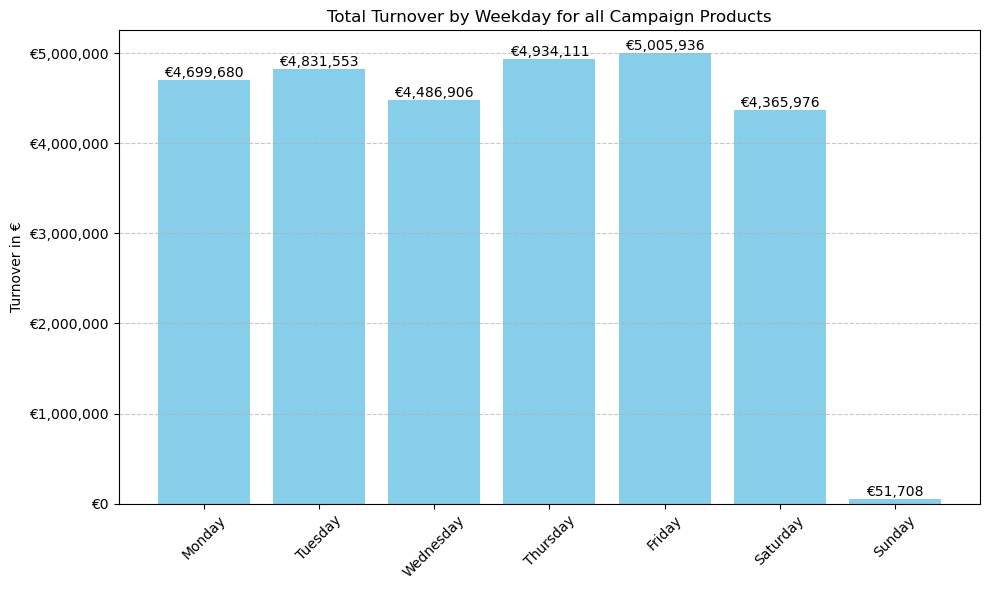

In [27]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Helper function for consistent formatting
def format_bars(ax, data, title):
    bars = ax.bar(weekday_order, data, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Turnover in €')
    ax.tick_params(axis='x', rotation=45)

    # Format y-axis with Euro symbol and thousands separator
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'€{height:,.0f}',
                ha='center', va='bottom', rotation=0)

    # Add grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    return bars

# Helper function to ensure all weekdays are present
def ensure_all_weekdays(series):
    missing_days = set(weekday_order) - set(series.index)
    for day in missing_days:
        series[day] = 0
    return series.reindex(weekday_order).fillna(0)

def analyze_weekday_turnover(df):
    """
    Analyzes pharmacy turnover by weekday, treating non-existent days as zero turnover.
    """
    df['weekday'] = df['timestamp'].dt.day_name()

    # Calculate total turnover by weekday
    total_turnover = ensure_all_weekdays(df.groupby('weekday')['amount'].sum())

    # Plot total turnover by weekday
    fig, ax = plt.subplots(figsize=(10, 6))
    format_bars(ax, total_turnover, 'Total Turnover by Weekday for all Campaign Products')

    plt.tight_layout()
    plt.show()

    return total_turnover

# Run the analysis
weekday_turnover_analyses = analyze_weekday_turnover(campaign_products_full_period)


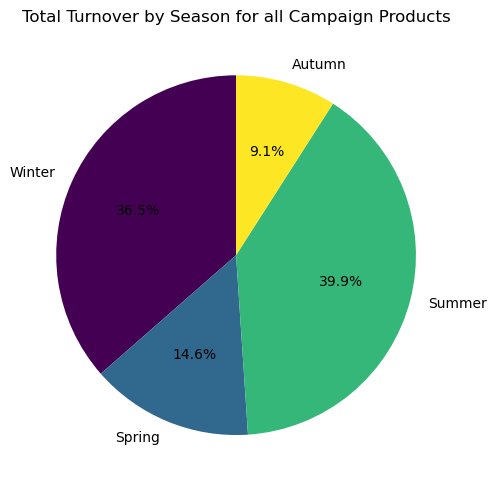

In [28]:
def get_season(date):
    """
    Determines the season based on the month of the given date.
    """
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def analyze_turnover_by_season(df):
    """
    Analyzes pharmacy turnover by season using a pie chart.
    """
    # Assign seasons based on timestamp
    df['season'] = df['timestamp'].apply(get_season)

    # Aggregate turnover by season
    season_turnover = df.groupby('season')['amount'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

    # Visualization
    fig, ax = plt.subplots(figsize=(8, 5))
    season_turnover.plot(
        kind='pie',
        ax=ax,
        colormap='viridis',
        autopct='%1.1f%%',
        startangle=90,
        legend=False,
        ylabel=''  # Hides the default ylabel
    )
    ax.set_title('Total Turnover by Season for all Campaign Products')
    plt.tight_layout()
    plt.show()

    return season_turnover

# Run the analysis
season_turnover_analysis = analyze_turnover_by_season(campaign_products_full_period)

---------------------------------------------------------------------------------------------------------------------------------------

# Web Scrapping

In [29]:
# Drop duplicate PZNs, keeping the most recent by sorting by 'timestamp' first
recent_eucerin_campaign_df = (
    eucerin_campaign_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    .head(10)
)
print(recent_eucerin_campaign_df)

                               transaction_id       pzn  amount  quantity  \
2233343  d78e4c18-c7f3-4776-b047-000000704181  10268643   28.89         1   
2267913  bb14fec7-6a80-43c1-b1a8-000000705039  13981063   21.95         1   
3075927  59720b23-440b-4b9c-b91d-000000705020  13889156   20.75         1   
2185056  f3f62f55-ee8f-416e-a345-000000705002  11678099   24.50         2   
323647   b12da48c-5b94-4943-bdb1-000000705050  06336209    9.95         1   
323646   b12da48c-5b94-4943-bdb1-000000705050  08454746   24.95         1   
1578061  6887ca7a-18e8-4d17-9043-000000704127  13889015   25.98         2   
2973312  41bf9c77-7f0d-479f-ac5b-000000704958  08454723   21.99         1   
2069620  f3e3e236-7584-42f6-8548-000000704953  15294332   22.98         1   
2193852  0b920497-5b13-4522-99d3-000000705045  13889021   16.48         1   

                               name retailer_id      gln zipcode_area pos_id  \
2233343  EUCERIN ANTIROET KASCH TAG        1051  1191944          484   

In [30]:
# Extract the PZN values and product names for these rows
selected_pzns = recent_eucerin_campaign_df[['pzn', 'name']]

# Base URL for searching PZNs
base_url = "https://www.medizinfuchs.de/?params%5Bsearch%5D={pzn}&params%5Bsearch_cat%5D=1"

# List to store scraped data
scraped_data = []

# Iterate through the PZNs and scrape data
for index, row in selected_pzns.iterrows():
    pzn = row['pzn']
    product_name = row['name']
    url = base_url.format(pzn=pzn)
    print(f"Fetching data for PZN: {pzn} from {url}")
    
    try:
        # Send GET request
        response = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"
        })
        
        # Ensure successful response
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Extract UVP (Suggested Retail Price)
            uvp_element = soup.find("div", class_="maxprice")
            uvp_price = uvp_element.find("span").get_text(strip=True).replace("€", "").replace(",", ".").split()[0] if uvp_element else "N/A"
            
            # Find all seller and price elements
            sellers = soup.find_all("div", class_="col-name")
            prices = soup.find_all("div", class_="col-price")
            
            # Extract seller names and prices
            for seller, price in zip(sellers, prices):
                seller_name = seller.find("strong").get_text(strip=True) if seller.find("strong") else "N/A"
                price_value = price.get_text(strip=True).replace("€", "").replace(",", ".").strip()
                scraped_data.append({
                    'PZN': pzn,
                    'Product Name': product_name,
                    'Seller': seller_name,
                    'Price (€)': float(price_value) if price_value else "N/A",
                    'UVP (€)': float(uvp_price) if uvp_price != "N/A" else "N/A"
                })
        else:
            print(f"Failed to fetch data for PZN: {pzn}. Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred for PZN: {pzn}. Error: {e}")

    # Add a 5-second delay between requests
    time.sleep(5)

# Convert scraped data to DataFrame
scraped_df = pd.DataFrame(scraped_data)

# Display and save the scraped data
print("Scraped Data:")
print(scraped_df)
scraped_df.to_csv("seller_price_data.csv", index=False)
print("Scraped data saved to 'seller_price_data.csv'.")


Fetching data for PZN: 10268643 from https://www.medizinfuchs.de/?params%5Bsearch%5D=10268643&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13981063 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13981063&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13889156 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13889156&params%5Bsearch_cat%5D=1
Fetching data for PZN: 11678099 from https://www.medizinfuchs.de/?params%5Bsearch%5D=11678099&params%5Bsearch_cat%5D=1
Fetching data for PZN: 06336209 from https://www.medizinfuchs.de/?params%5Bsearch%5D=06336209&params%5Bsearch_cat%5D=1
Fetching data for PZN: 08454746 from https://www.medizinfuchs.de/?params%5Bsearch%5D=08454746&params%5Bsearch_cat%5D=1
Fetching data for PZN: 13889015 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13889015&params%5Bsearch_cat%5D=1
Fetching data for PZN: 08454723 from https://www.medizinfuchs.de/?params%5Bsearch%5D=08454723&params%5Bsearch_cat%5D=1
Fetching data for PZN: 15294332 from https://www

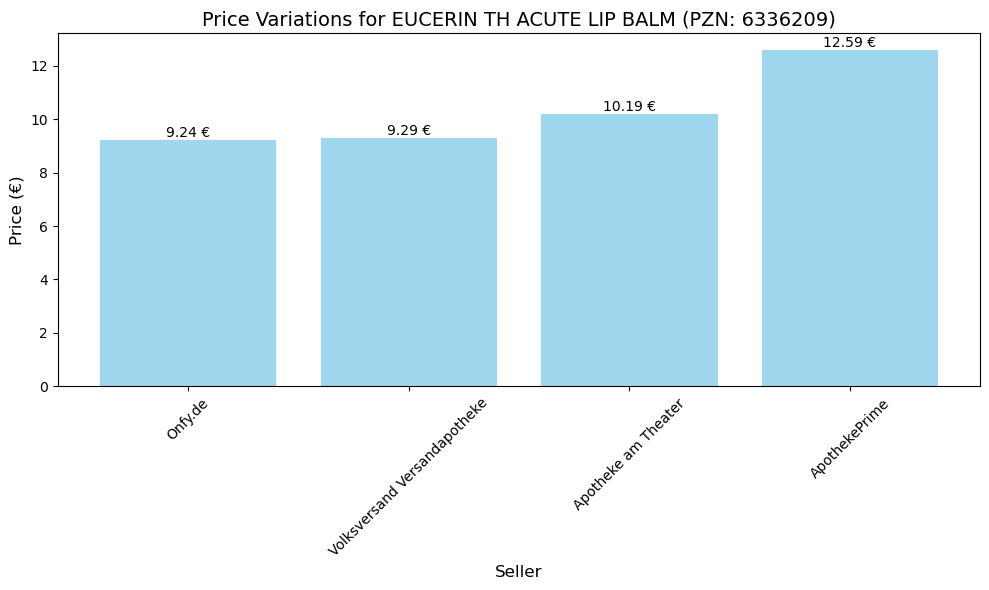

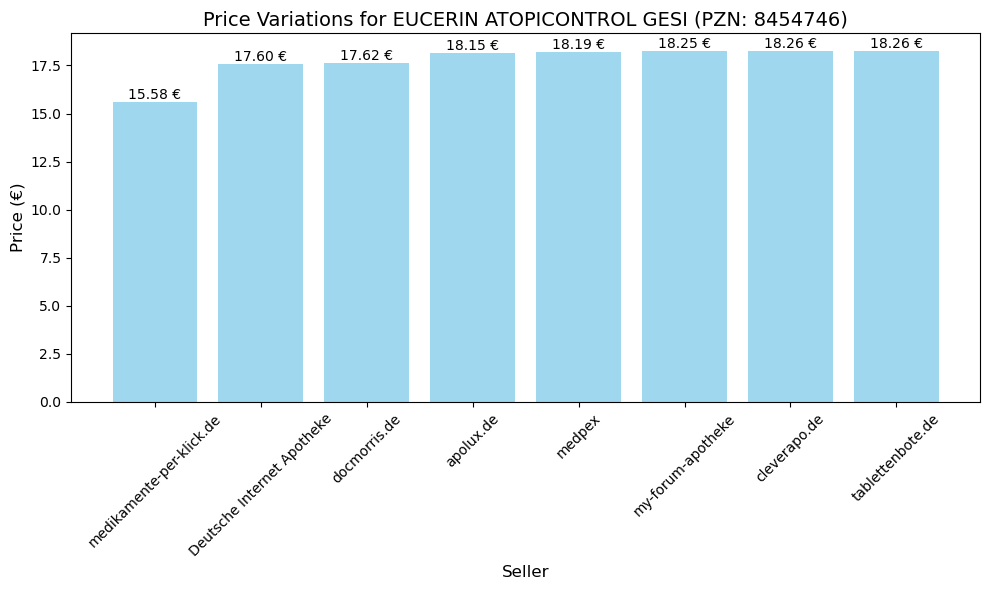

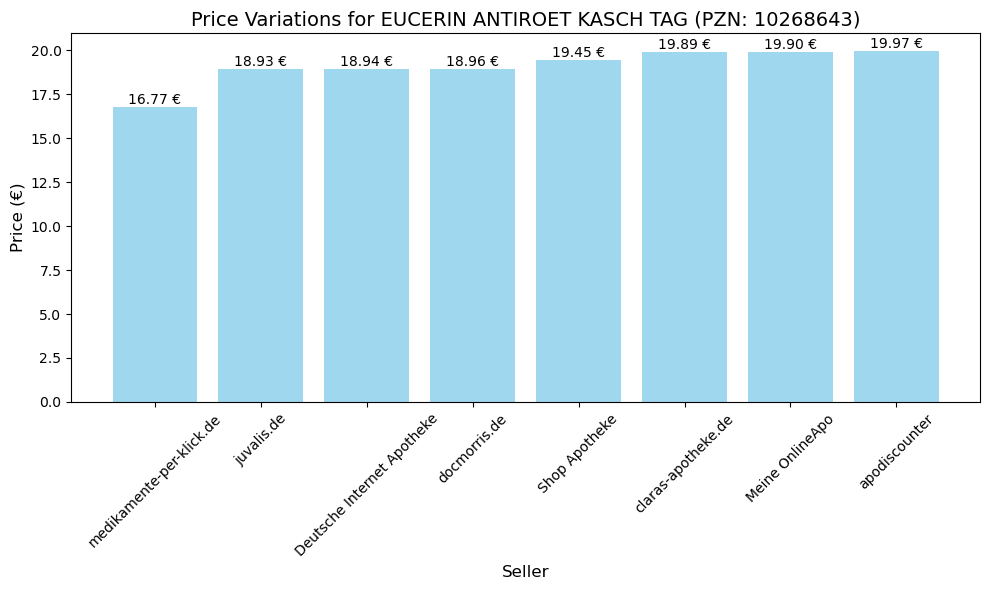

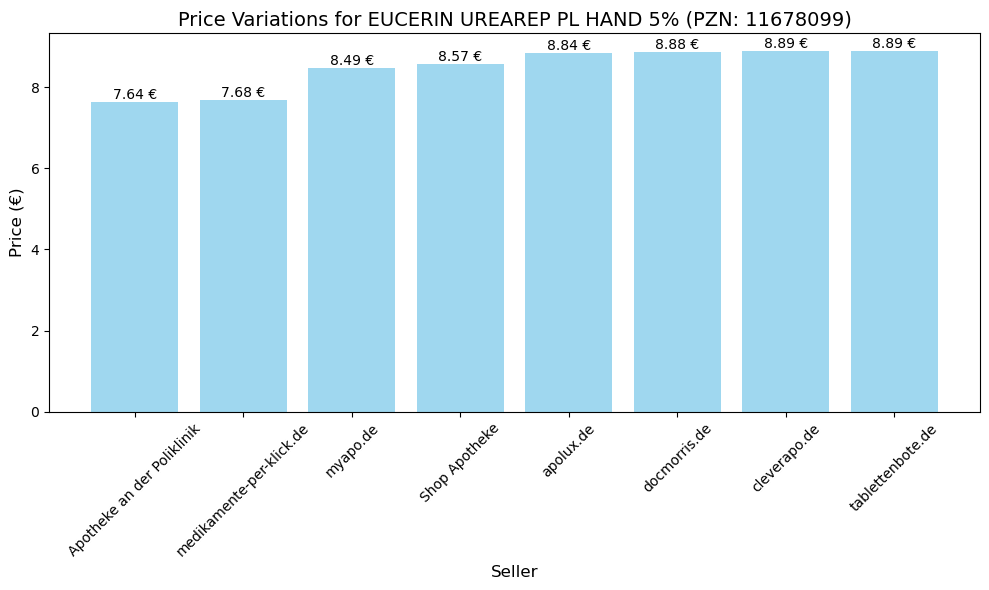

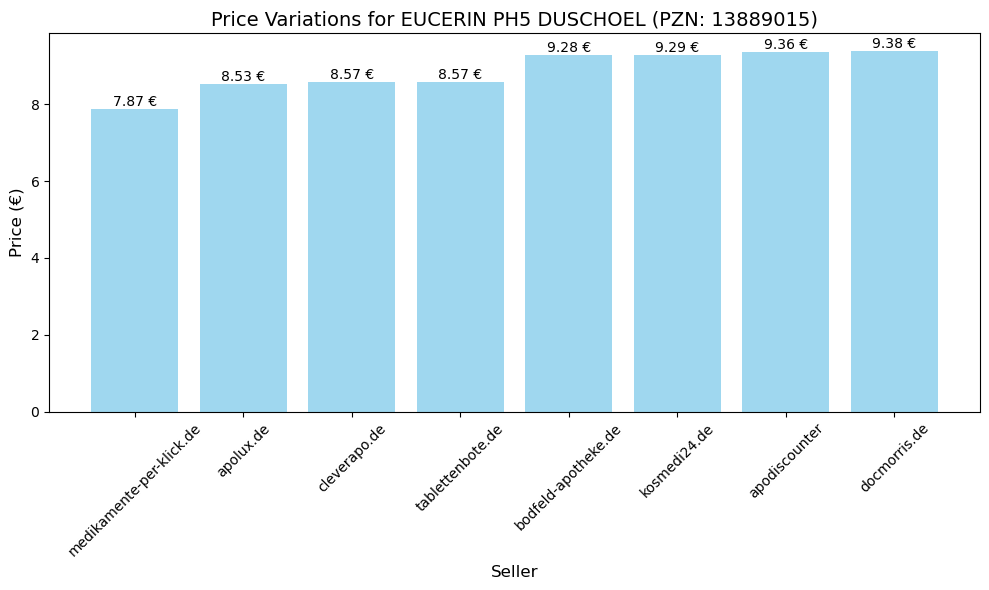

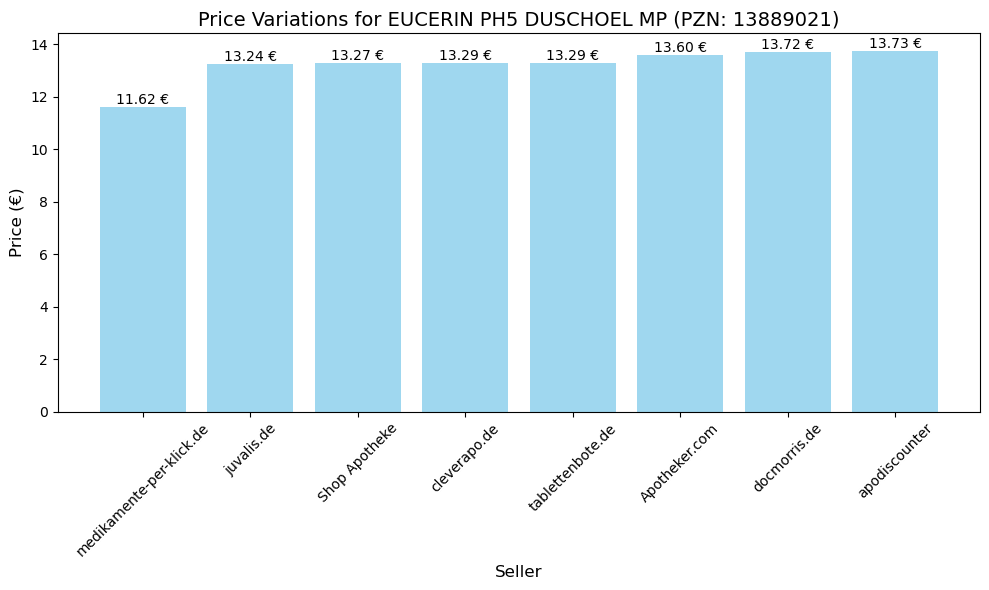

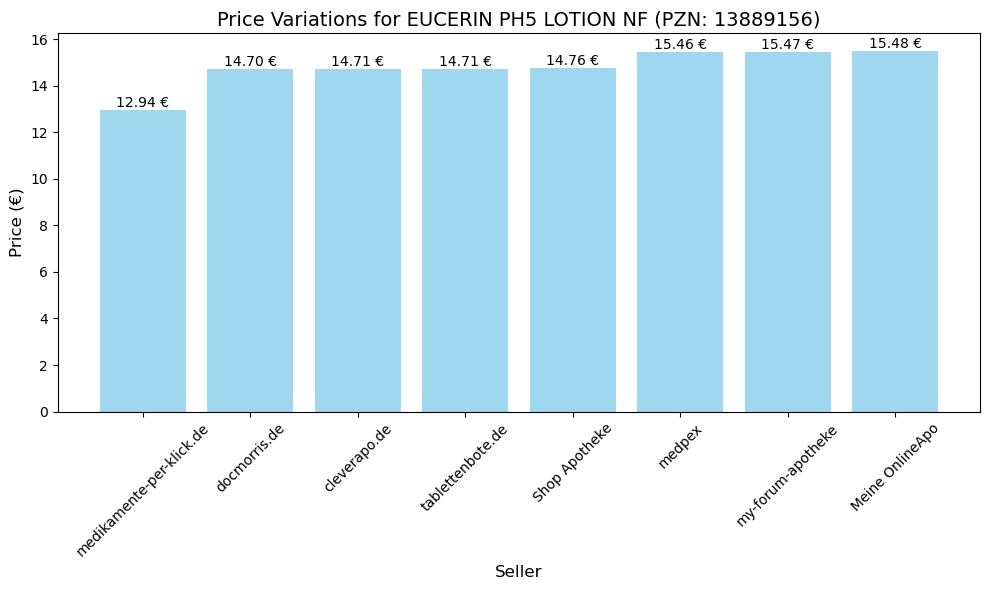

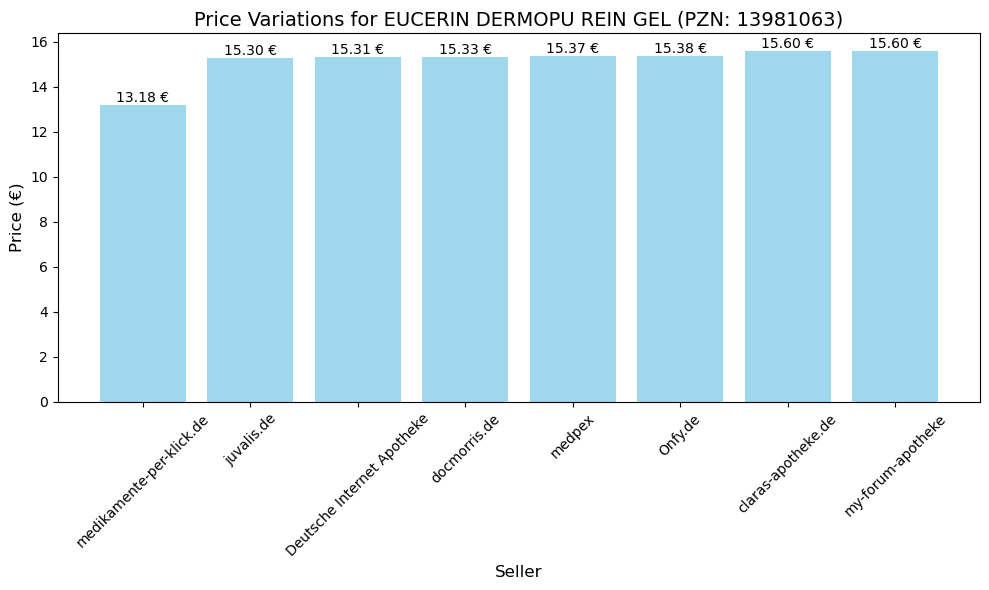

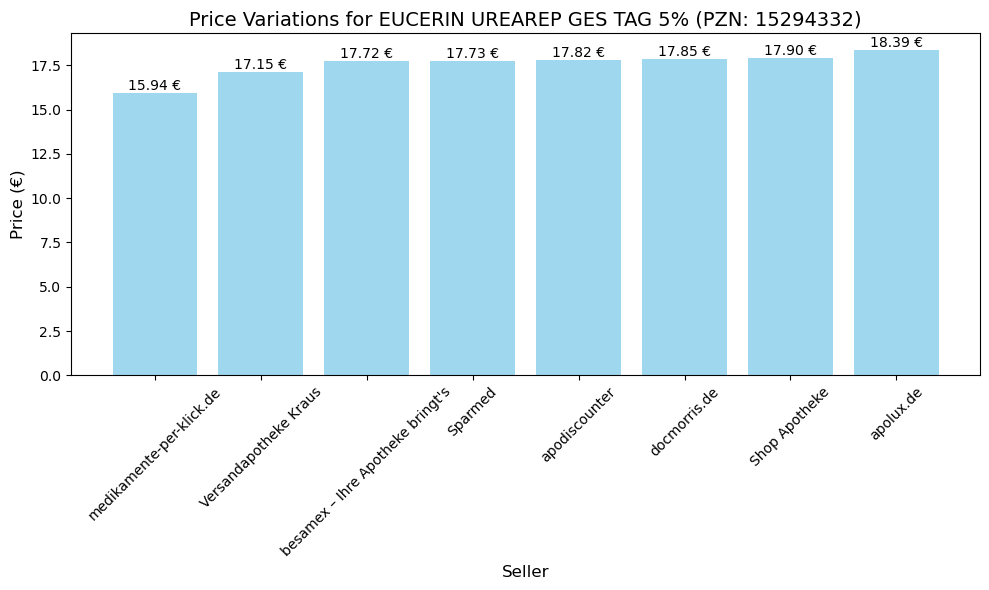

In [31]:
scraped_df =  pd.read_csv(f"seller_price_data.csv") 
# Group data by PZN
grouped_data = scraped_df.groupby("PZN")

# Create a graph for each PZN
for pzn, group in grouped_data:
    # Get the product name (assuming it's consistent for the same PZN)
    product_name = group["Product Name"].iloc[0]
    
    # Plot seller vs price for the current PZN
    plt.figure(figsize=(10, 6))
    bars = plt.bar(group["Seller"], group["Price (€)"], color='skyblue', alpha=0.8)
    
    # Add prices on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f} €", ha='center', va='bottom', fontsize=10)
    
    # Add title and labels
    plt.title(f"Price Variations for {product_name} (PZN: {pzn})", fontsize=14)
    plt.xlabel("Seller", fontsize=12)
    plt.ylabel("Price (€)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    
    # Display the chart
    plt.tight_layout()
    plt.show()


# Compare the pzn amounts of offline (eucerin_campaign_df) pzns price and online pzns price

In [32]:

# Extract the 10 most recent PZNs
recent_pzns = recent_eucerin_campaign_df['pzn'].tolist()

# Filter the full campaign data for these 10 PZNs
filtered_campaign_data = eucerin_campaign_df[eucerin_campaign_df['pzn'].isin(recent_pzns)]

# Calculate minimum and average "amount" values for each PZN
aggregated_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Merge the aggregated data with recent_eucerin_campaign_df to include additional columns (if needed)
result_df = recent_eucerin_campaign_df.merge(aggregated_data, on='pzn', how='left')

# Display the result
print("Recent PZNs with Minimum and Average 'amount' Values:")
print(result_df[['pzn', 'name', 'min_amount', 'avg_amount']])

# Save the result to a CSV file
result_df.to_csv("eucerin_min_avg_amount.csv", index=False)
print("Result saved to 'eucerin_min_avg_amount.csv'.")


Recent PZNs with Minimum and Average 'amount' Values:
        pzn                        name  min_amount  avg_amount
0  10268643  EUCERIN ANTIROET KASCH TAG       17.58   25.552506
1  13981063    EUCERIN DERMOPU REIN GEL        1.75   21.251592
2  13889156       EUCERIN PH5 LOTION NF       13.40   21.100147
3  11678099  EUCERIN UREAREP PL HAND 5%        5.95   14.070872
4  06336209   EUCERIN TH ACUTE LIP BALM        3.25   11.293718
5  08454746   EUCERIN ATOPICONTROL GESI        5.95   24.415755
6  13889015        EUCERIN PH5 DUSCHOEL        5.75   13.066338
7  08454723  EUCERIN ATOPICONTROL CREME       15.89   22.515293
8  15294332  EUCERIN UREAREP GES TAG 5%       15.54   24.576941
9  13889021     EUCERIN PH5 DUSCHOEL MP       11.51   18.766056
Result saved to 'eucerin_min_avg_amount.csv'.


In [33]:
# Load the data
seller_price_data = pd.read_csv("seller_price_data.csv")

# Ensure PZN numbers are 8 digits long in both datasets before converting to strings
eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")
seller_price_data['PZN'] = seller_price_data['PZN'].apply(lambda x: f"{int(x):08d}")

# Sort the campaign data by 'timestamp' and drop duplicates for recent PZNs
recent_eucerin_campaign_df = (
    eucerin_campaign_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    .head(10)
)

# Extract the most recent PZNs
recent_pzns = recent_eucerin_campaign_df['pzn'].tolist()

# Filter the full campaign data for these PZNs
filtered_campaign_data = eucerin_campaign_df[eucerin_campaign_df['pzn'].isin(recent_pzns)]

# Calculate minimum and average "amount" values for each PZN in the campaign data
aggregated_campaign_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Calculate minimum and average "Price (€)" values for each PZN in the seller price data
aggregated_seller_data = (
    seller_price_data.groupby('PZN')
    .agg(
        min_seller_price=('Price (€)', 'min'),
        avg_seller_price=('Price (€)', 'mean')
    )
    .reset_index()
    .rename(columns={'PZN': 'pzn'})
)

# Merge the aggregated campaign and seller data
comparison_df = aggregated_campaign_data.merge(aggregated_seller_data, on='pzn', how='inner')

# Calculate the differences
comparison_df['Min Price Difference'] = comparison_df['min_amount'] - comparison_df['min_seller_price']
comparison_df['Avg Price Difference'] = comparison_df['avg_amount'] - comparison_df['avg_seller_price']

# Add cheaper/higher comparison for minimum and average prices with price difference
comparison_df['Min Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Min Price Difference']:.2f} ({'Online Cheaper' if row['Min Price Difference'] > 0 else 'Online Higher' if row['Min Price Difference'] < 0 else 'Same Price'})",
    axis=1
)
comparison_df['Avg Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Avg Price Difference']:.2f} ({'Online Cheaper' if row['Avg Price Difference'] > 0 else 'Online Higher' if row['Avg Price Difference'] < 0 else 'Same Price'})",
    axis=1
)

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Merge with recent_eucerin_campaign_df to include product names
result_df = recent_eucerin_campaign_df[['pzn', 'name']].merge(comparison_df, on='pzn', how='inner')

# Rename columns for better readability
result_df = result_df.rename(columns={
    'min_amount': 'Offline Min Price',
    'avg_amount': 'Offline Avg Price',
    'min_seller_price': 'Online Min Price',
    'avg_seller_price': 'Online Avg Price'
})

# Display the result
print("Comparison of Offline and Online Data:")
print(result_df[['pzn', 'name', 'Offline Min Price', 'Offline Avg Price', 'Online Min Price', 'Online Avg Price', 'Min Price Comparison', 'Avg Price Comparison']])

# Save the result to a CSV file
result_df.to_csv("eucerin_price_comparison.csv", index=False)


Comparison of Offline and Online Data:
        pzn                        name  Offline Min Price  Offline Avg Price  \
0  10268643  EUCERIN ANTIROET KASCH TAG              17.58              25.55   
1  13981063    EUCERIN DERMOPU REIN GEL               1.75              21.25   
2  13889156       EUCERIN PH5 LOTION NF              13.40              21.10   
3  11678099  EUCERIN UREAREP PL HAND 5%               5.95              14.07   
4  06336209   EUCERIN TH ACUTE LIP BALM               3.25              11.29   
5  08454746   EUCERIN ATOPICONTROL GESI               5.95              24.42   
6  13889015        EUCERIN PH5 DUSCHOEL               5.75              13.07   
7  15294332  EUCERIN UREAREP GES TAG 5%              15.54              24.58   
8  13889021     EUCERIN PH5 DUSCHOEL MP              11.51              18.77   

   Online Min Price  Online Avg Price    Min Price Comparison  \
0             16.77             19.10   0.81 (Online Cheaper)   
1             13.18 

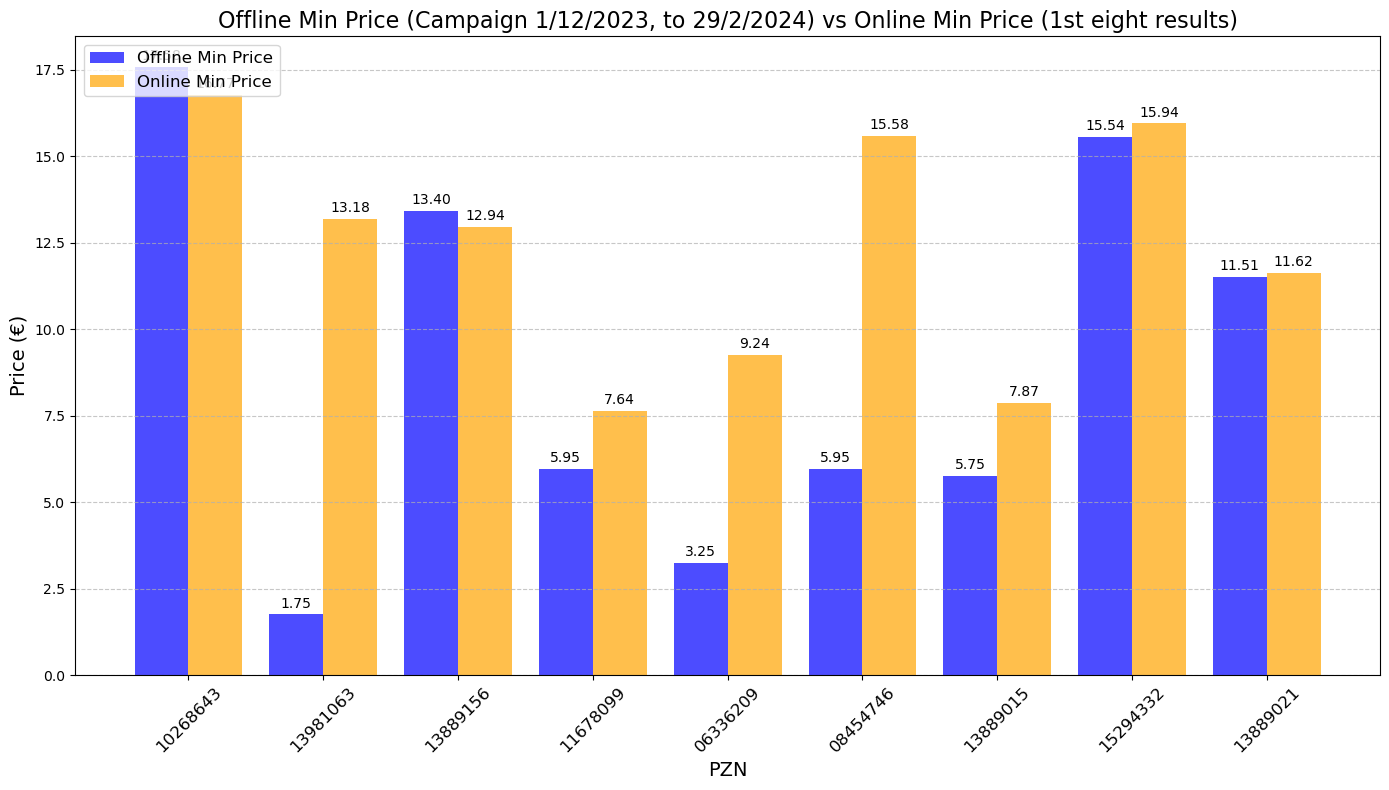

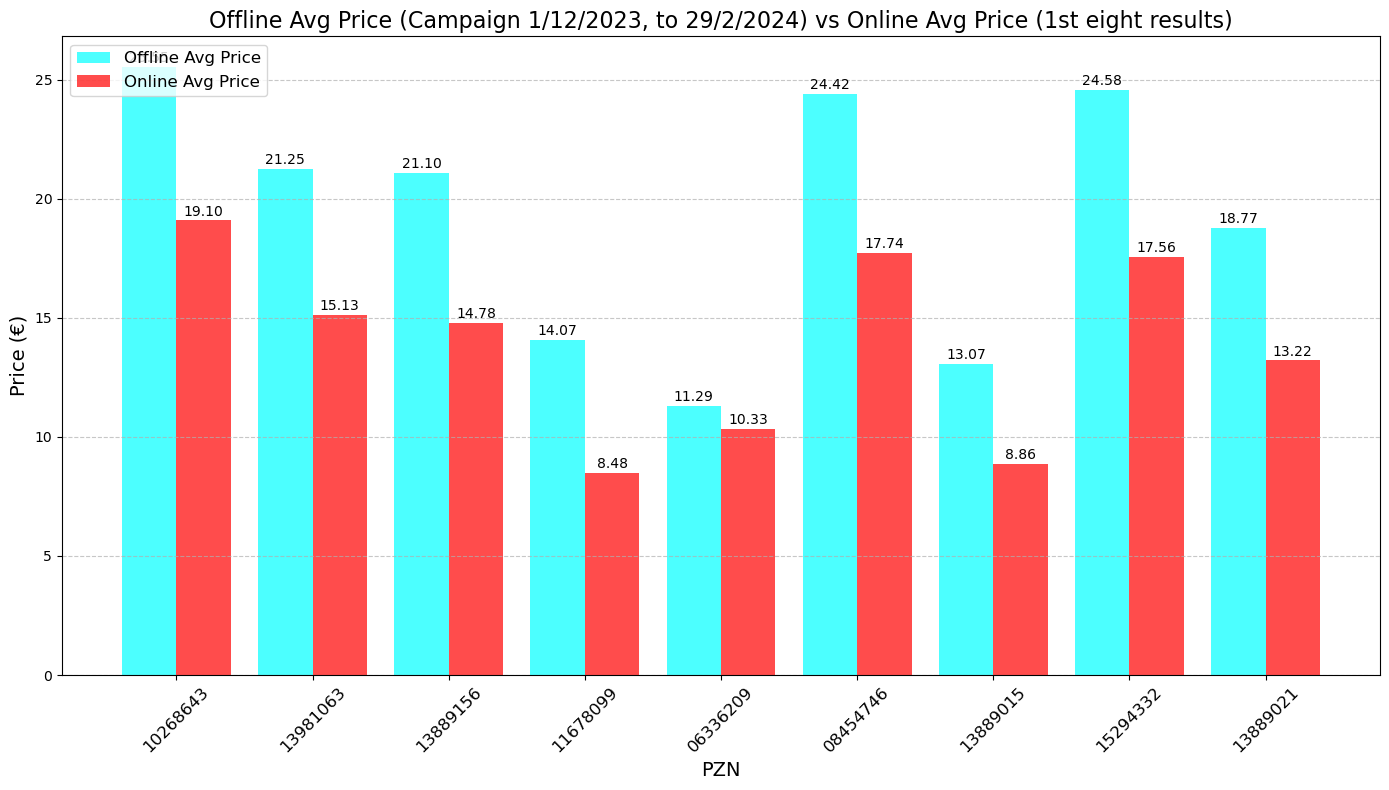

In [34]:

# Chart 1: Offline Min Price vs Online Min Price
plt.figure(figsize=(14, 8))
bar_width = 0.4
positions = range(len(result_df))

# Plot Offline Min Prices
offline_min_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Min Price'],
    width=bar_width,
    color='blue',
    alpha=0.7,
    label="Offline Min Price"
)

# Plot Online Min Prices
online_min_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Min Price'],
    width=bar_width,
    color='orange',
    alpha=0.7,
    label="Online Min Price"
)

# Add price labels to bars
for bar in offline_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Min Price (Campaign 1/12/2023, to 29/2/2024) vs Online Min Price (1st eight results)", fontsize=16)
plt.xlabel("PZN", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['pzn'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chart 2: Offline Avg Price vs Online Avg Price
plt.figure(figsize=(14, 8))

# Plot Offline Avg Prices
offline_avg_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Avg Price'],
    width=bar_width,
    color='cyan',
    alpha=0.7,
    label="Offline Avg Price"
)

# Plot Online Avg Prices
online_avg_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Avg Price'],
    width=bar_width,
    color='red',
    alpha=0.7,
    label="Online Avg Price"
)

# Add price labels to bars
for bar in offline_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Avg Price (Campaign 1/12/2023, to 29/2/2024) vs Online Avg Price (1st eight results)", fontsize=16)
plt.xlabel("PZN", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['pzn'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Compare campaign prices with the recommeded retail price

In [35]:
# Load the seller price data
seller_price_data = pd.read_csv("seller_price_data.csv")

# Convert PZN columns to string format
eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")
seller_price_data['PZN'] = seller_price_data['PZN'].apply(lambda x: f"{int(x):08d}")

# Sort the campaign data by 'timestamp' (most recent first) and keep the latest 10 products
recent_eucerin_campaign_df = (
    eucerin_campaign_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    .head(10)
)

# Extract the most recent PZNs
recent_pzns = recent_eucerin_campaign_df['pzn'].tolist()

# Filter the campaign data to only include these PZNs
filtered_campaign_data = eucerin_campaign_df[eucerin_campaign_df['pzn'].isin(recent_pzns)]

# Calculate the minimum and average campaign prices for each PZN
aggregated_campaign_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Aggregate the UVP data: min UVP and mean UVP for each PZN
aggregated_seller_data = (
    seller_price_data.groupby('PZN')
    .agg(
        uvp_mean=('UVP (€)', 'mean')  # Mean UVP price
    )
    .reset_index()
    .rename(columns={'PZN': 'pzn'})
)

# Merge the campaign price data with the UVP data
comparison_df = aggregated_campaign_data.merge(aggregated_seller_data, on='pzn', how='inner')

# Calculate the price difference compared to UVP
comparison_df['Avg Price Difference'] = comparison_df['avg_amount'] - comparison_df['uvp_mean']

# Add a comparison label: Is the campaign price below, above, or the same 
comparison_df['Avg Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Avg Price Difference']:.2f} ({'Below UVP' if row['Avg Price Difference'] < 0 else 'Above UVP' if row['Avg Price Difference'] > 0 else 'Same as UVP'})",
    axis=1
)

comparison_df = comparison_df.round(2)

# Merge with the recent campaign data to include product names
result_df = recent_eucerin_campaign_df[['pzn', 'name']].merge(comparison_df, on='pzn', how='inner')

# Rename columns for better readability
result_df = result_df.rename(columns={
    'avg_amount': 'Campaign Avg Price',
    'uvp_mean': 'Mean UVP (€)'
})

print("Comparison of Campaign Prices vs. UVP:")
print(result_df[['pzn', 'name', 'Campaign Avg Price',  'Mean UVP (€)', 'Avg Price Comparison']])

# Save the results to a CSV file
result_df.to_csv("eucerin_uvp_comparison.csv", index=False)

Comparison of Campaign Prices vs. UVP:
        pzn                        name  Campaign Avg Price  Mean UVP (€)  \
0  10268643  EUCERIN ANTIROET KASCH TAG               25.55         29.25   
1  13981063    EUCERIN DERMOPU REIN GEL               21.25         22.25   
2  13889156       EUCERIN PH5 LOTION NF               21.10         21.45   
3  11678099  EUCERIN UREAREP PL HAND 5%               14.07         12.95   
4  06336209   EUCERIN TH ACUTE LIP BALM               11.29         10.25   
5  08454746   EUCERIN ATOPICONTROL GESI               24.42         26.95   
6  13889015        EUCERIN PH5 DUSCHOEL               13.07         13.25   
7  15294332  EUCERIN UREAREP GES TAG 5%               24.58         26.95   
8  13889021     EUCERIN PH5 DUSCHOEL MP               18.77         19.25   

  Avg Price Comparison  
0    -3.70 (Below UVP)  
1    -1.00 (Below UVP)  
2    -0.35 (Below UVP)  
3     1.12 (Above UVP)  
4     1.04 (Above UVP)  
5    -2.53 (Below UVP)  
6    -0.18 (Bel

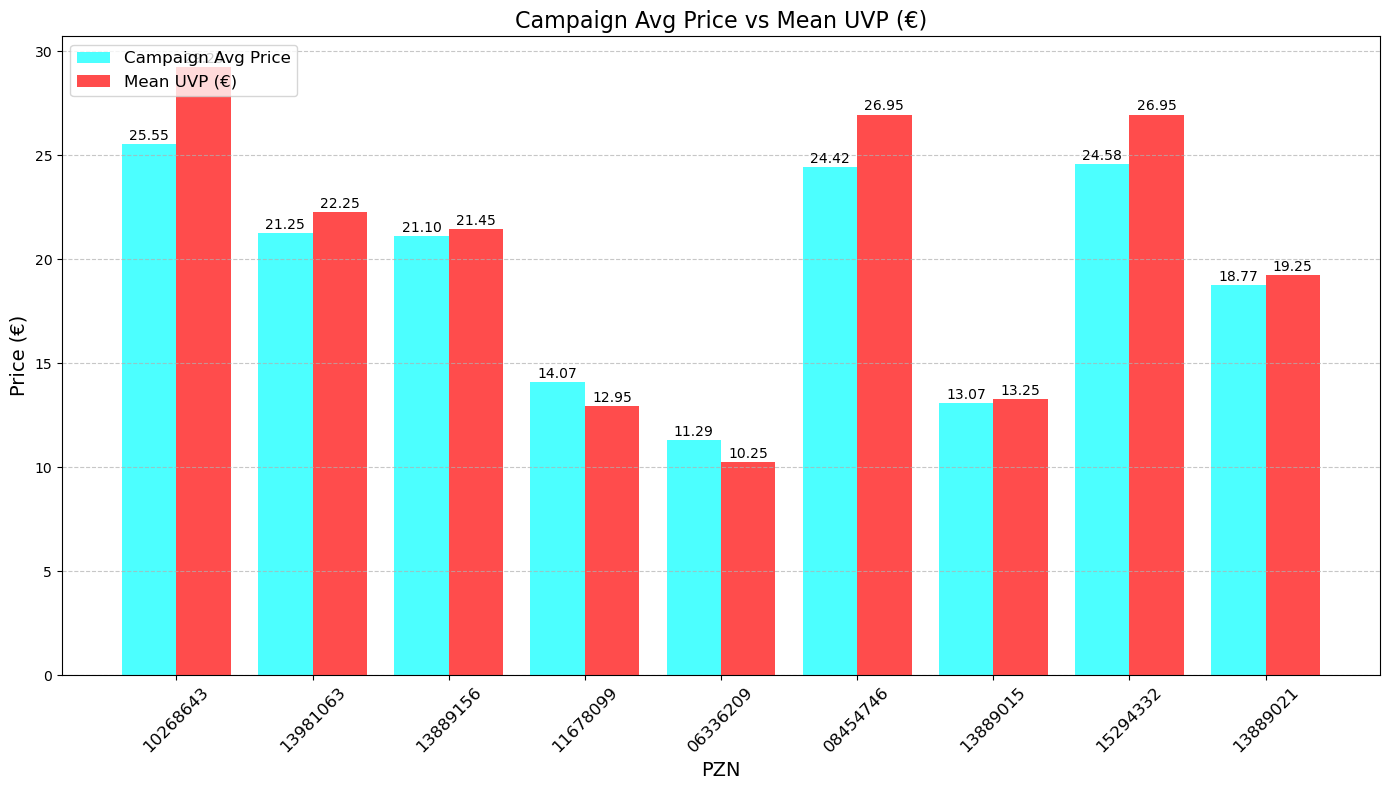

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Set up bar width and positions
bar_width = 0.4
positions = np.arange(len(result_df))

# Plot for Avg Price Comparison
plt.figure(figsize=(14, 8))

# Campaign Avg Price
campaign_avg_bars = plt.bar(
    positions - bar_width / 2,
    result_df['Campaign Avg Price'],
    width=bar_width,
    color='cyan',
    alpha=0.7,
    label="Campaign Avg Price"
)

# Mean UVP (€)
uvp_avg_bars = plt.bar(
    positions + bar_width / 2,
    result_df['Mean UVP (€)'],
    width=bar_width,
    color='red',
    alpha=0.7,
    label="Mean UVP (€)"
)

# Add value labels on top of the bars
for bar in campaign_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in uvp_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Campaign Avg Price vs Mean UVP (€)", fontsize=16)
plt.xlabel("PZN", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['pzn'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* Find the top 5 L'Oréal Group Non Promotional Items by Revenue

In [45]:
# non_promotional_items_df = campaign_df[~campaign_df['name'].str.contains('Eucerin', case=False, na=False)] <- From before

# Top 20 non promotional products by revenue
non_prom_products = non_promotional_items_df.groupby('pzn')['amount'].sum().sort_values(ascending=False).head(50)

results = []
for pzn in non_prom_products.index:
    product = {"pzn": pzn, "name": products_df[products_df['pzn'] == pzn]['name'].values[0]}
    total_amount = non_promotional_items_df[non_promotional_items_df['pzn'] == pzn]['amount'].sum()
    total_quantity = non_promotional_items_df[non_promotional_items_df['pzn'] == pzn]['quantity'].sum()
    average_price = total_amount / total_quantity
    product['average_price'] = average_price

    #  number of items sold
    product['number_of_items_sold'] = total_quantity

    # number of receipts
    product['number_of_receipts'] = non_promotional_items_df[non_promotional_items_df['pzn'] == pzn]['transaction_id'].nunique()

    results.append(product)

# write the top 20 products to a csv file
results = pd.DataFrame(results)
# number should only 2 decimal points
results['average_price'] = results['average_price'].round(2)
results.to_csv('top_20_np_products.csv', index=False)

* Check results

In [46]:
results
#Consider ROCHE POSAY products belong to L'Oréal Group

,pzn,name,average_price,number_of_items_sold,number_of_receipts
0,04002065,PRIORIN,46.19,996,981
1,16563662,ORTHOMOL HAIR INTENSE,29.34,494,468
2,01997030,REGAINE FRAUEN,60.58,236,230
3,18215149,NICORETTE MINT 1MG/SP NFC,33.57,388,362
4,16866061,ORTHOMOL HAIR INTENSE,73.50,162,159
5,18215155,NICORETTE MINT 1MG/SP NFC,60.54,195,185
6,03671166,REGAINE MAENNER,81.07,142,130
7,09100275,REGAINE MAENNER SCHAUM 5%,74.61,151,146
8,15266092,PRIORIN,82.64,132,129
9,11240397,VOLTAREN SCHM FORT23.2MG/G,27.59,374,348


* Filter the PZN corresponding to the products

In [47]:
selected = ['13864498', '16349153', '17507772', '17636587', '18719861']
loreal_prod = results[results['pzn'].isin(selected)]
loreal_prod

,pzn,name,average_price,number_of_items_sold,number_of_receipts
25,13864498,ROCHE POSAY HYALU B5 SERUM,40.67,167,162
30,16349153,ROCHE POSAY LIPI BAUM AP+M,23.80,242,230
35,17507772,ROCHE POSAY DERMALL AUGEN,21.03,236,225
36,17636587,ROCHE POSAY ANT INV UVM 50,21.80,224,204
43,18719861,ROCHE POSAY EFFACLAR DUO+M,20.05,216,211


* Report Minimum and Average Price for the products

In [48]:
# Extract the PZN values and product names for these rows
loreal_prod_select = loreal_prod[['pzn', 'name']]

filtered_np_campaign_data = non_promotional_items_df[non_promotional_items_df['pzn'].isin(selected)]

# Calculate minimum and average "amount" values for each PZN
nonprom_aggregated_data = (
    filtered_np_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Merge the aggregated data with recent_eucerin_campaign_df to include additional columns (if needed)
nonprom_result_df = nonprom_aggregated_data.merge(loreal_prod_select, on='pzn', how='left')

# Display the result
print("Recent PZNs with Minimum and Average 'amount' Values:")
print(nonprom_result_df[['pzn', 'name', 'min_amount', 'avg_amount']])

# Save the result to a CSV file
nonprom_result_df.to_csv("nonprom_eucerin_min_avg_amount.csv", index=False)
print("Result saved to 'nonprom_eucerin_min_avg_amount.csv'.")

Recent PZNs with Minimum and Average 'amount' Values:
        pzn                        name  min_amount  avg_amount
0  13864498  ROCHE POSAY HYALU B5 SERUM       26.96   41.924074
1  16349153  ROCHE POSAY LIPI BAUM AP+M       17.10   25.043696
2  17507772   ROCHE POSAY DERMALL AUGEN       15.00   22.059467
3  17636587  ROCHE POSAY ANT INV UVM 50       14.95   23.934265
4  18719861  ROCHE POSAY EFFACLAR DUO+M       12.76   20.524834
Result saved to 'nonprom_eucerin_min_avg_amount.csv'.


* Web Scrapping to get the current prices for the products

In [49]:
# Base URL for searching PZNs
base_url = "https://www.medizinfuchs.de/?params%5Bsearch%5D={pzn}&params%5Bsearch_cat%5D=1"

# List to store scraped data
scraped_data = []

# Iterate through the PZNs and scrape data
for index, row in loreal_prod_select.iterrows():
    pzn = row['pzn']
    product_name = row['name']
    url = base_url.format(pzn=pzn)
    print(f"Fetching data for PZN: {pzn} from {url}")
    
    try:
        # Send GET request
        response = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"
        })
        
        # Ensure successful response
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Extract UVP (Suggested Retail Price)
            uvp_element = soup.find("div", class_="maxprice")
            uvp_price = uvp_element.find("span").get_text(strip=True).replace("€", "").replace(",", ".").split()[0] if uvp_element else "N/A"
            
            # Find all seller and price elements
            sellers = soup.find_all("div", class_="col-name")
            prices = soup.find_all("div", class_="col-price")
            
            # Extract seller names and prices
            for seller, price in zip(sellers, prices):
                seller_name = seller.find("strong").get_text(strip=True) if seller.find("strong") else "N/A"
                price_value = price.get_text(strip=True).replace("€", "").replace(",", ".").strip()
                scraped_data.append({
                    'PZN': pzn,
                    'Product Name': product_name,
                    'Seller': seller_name,
                    'Price (€)': float(price_value) if price_value else "N/A",
                    'UVP (€)': float(uvp_price) if uvp_price != "N/A" else "N/A"
                })
        else:
            print(f"Failed to fetch data for PZN: {pzn}. Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred for PZN: {pzn}. Error: {e}")

    # Add a 5-second delay between requests
    time.sleep(5)

# Convert scraped data to DataFrame
scraped_nonprom_df = pd.DataFrame(scraped_data)

# Display and save the scraped data
print("Scraped Data:")
print(scraped_nonprom_df)
scraped_nonprom_df.to_csv("non_prom_seller_price_data.csv", index=False)
print("Scraped data saved to 'non_prom_seller_price_data.csv'.")

Fetching data for PZN: 13864498 from https://www.medizinfuchs.de/?params%5Bsearch%5D=13864498&params%5Bsearch_cat%5D=1
Fetching data for PZN: 16349153 from https://www.medizinfuchs.de/?params%5Bsearch%5D=16349153&params%5Bsearch_cat%5D=1
Fetching data for PZN: 17507772 from https://www.medizinfuchs.de/?params%5Bsearch%5D=17507772&params%5Bsearch_cat%5D=1
Fetching data for PZN: 17636587 from https://www.medizinfuchs.de/?params%5Bsearch%5D=17636587&params%5Bsearch_cat%5D=1
Fetching data for PZN: 18719861 from https://www.medizinfuchs.de/?params%5Bsearch%5D=18719861&params%5Bsearch_cat%5D=1
Scraped Data:
         PZN                Product Name                            Seller  \
0   13864498  ROCHE POSAY HYALU B5 SERUM          ipill.de Versandapotheke   
1   13864498  ROCHE POSAY HYALU B5 SERUM                          aposalis   
2   13864498  ROCHE POSAY HYALU B5 SERUM                     Shop Apotheke   
3   13864498  ROCHE POSAY HYALU B5 SERUM                           Sparmed   
4

* Plot the Prices by Seller

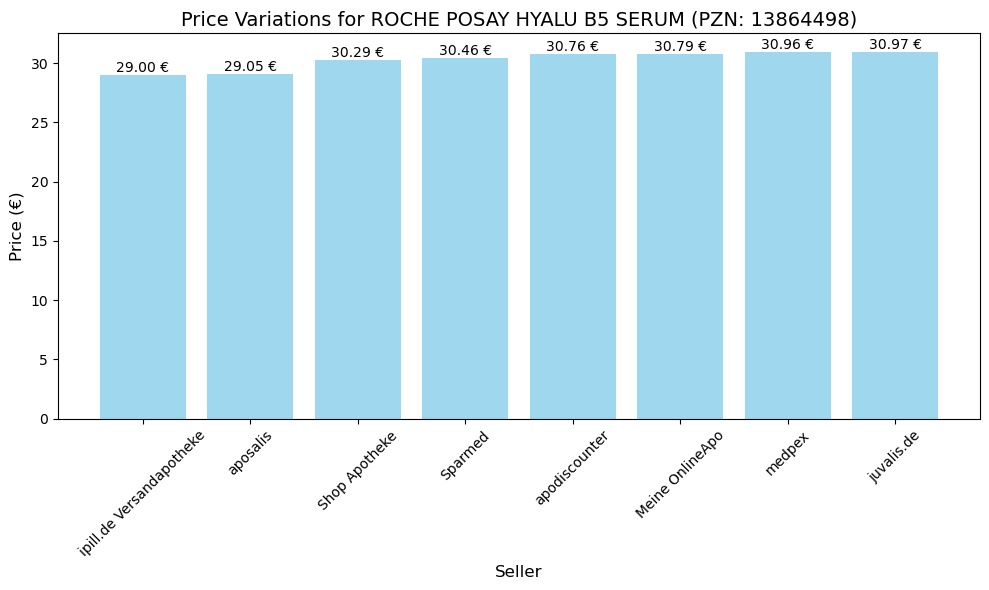

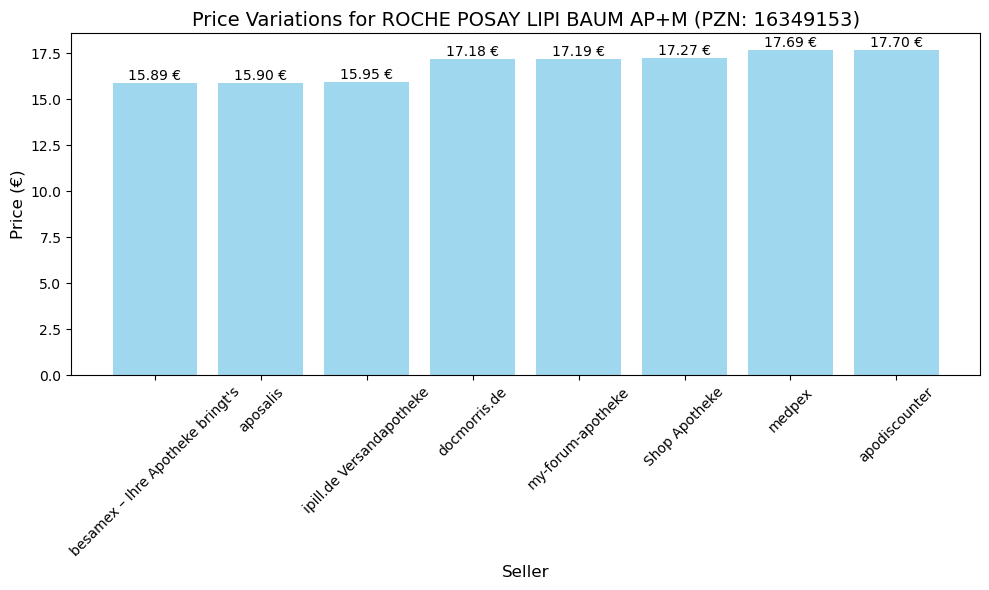

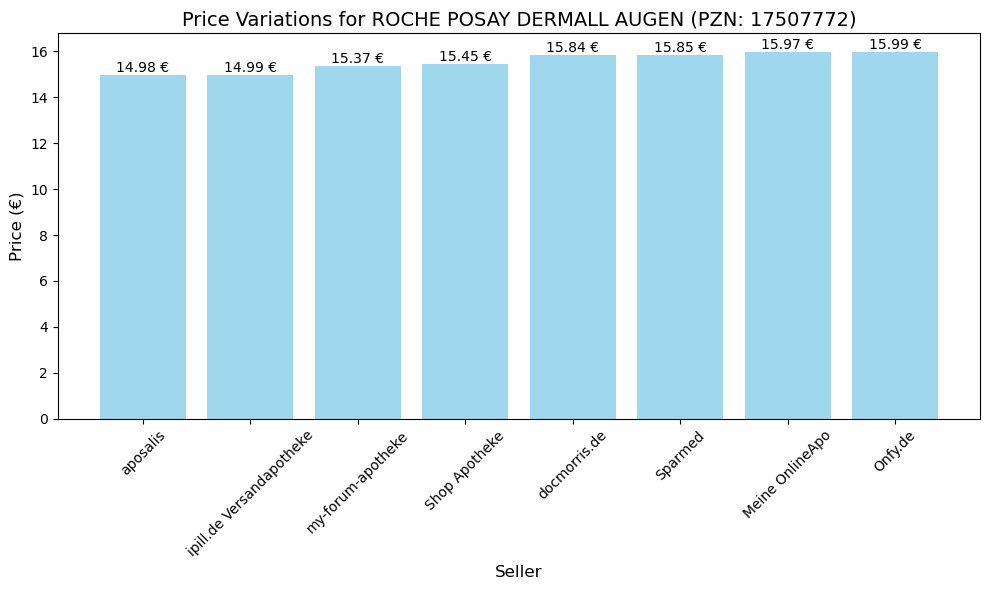

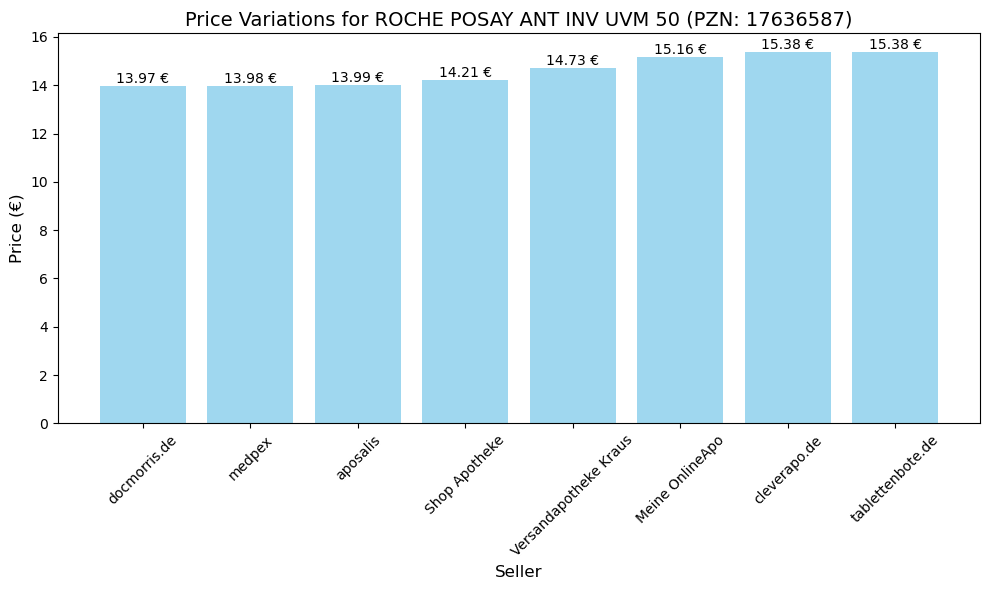

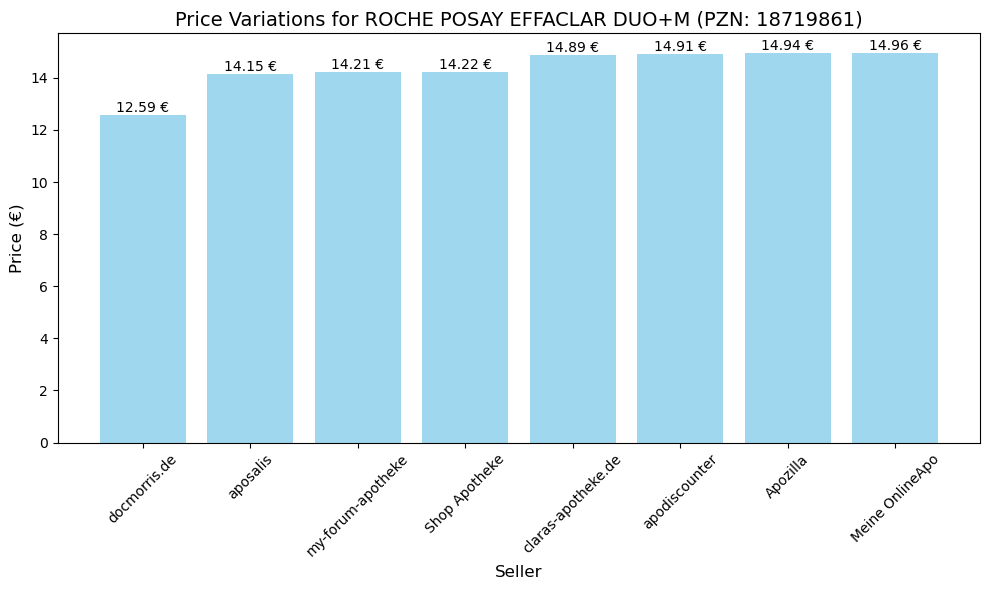

In [50]:
scraped_df =  pd.read_csv(f"non_prom_seller_price_data.csv") 
# Group data by PZN
grouped_data = scraped_df.groupby("PZN")

# Create a graph for each PZN
for pzn, group in grouped_data:
    # Get the product name (assuming it's consistent for the same PZN)
    product_name = group["Product Name"].iloc[0]
    
    # Plot seller vs price for the current PZN
    plt.figure(figsize=(10, 6))
    bars = plt.bar(group["Seller"], group["Price (€)"], color='skyblue', alpha=0.8)
    
    # Add prices on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f} €", ha='center', va='bottom', fontsize=10)
    
    # Add title and labels
    plt.title(f"Price Variations for {product_name} (PZN: {pzn})", fontsize=14)
    plt.xlabel("Seller", fontsize=12)
    plt.ylabel("Price (€)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    
    # Display the chart
    plt.tight_layout()
    plt.show()

* Compare Offline Prices with Online Current Prices

In [51]:
# Load the data
seller_price_data = pd.read_csv("non_prom_seller_price_data.csv")

# Sort the campaign data by 'timestamp' and drop duplicates for recent PZNs
recent_non_prom_prod_df = (
    non_promotional_items_df.sort_values(by='timestamp', ascending=False)
    .drop_duplicates(subset='pzn')
    #.head(10)
)

# Ensure PZN numbers are 8 digits long in both datasets before converting to strings
eucerin_campaign_df['pzn'] = eucerin_campaign_df['pzn'].apply(lambda x: f"{int(x):08d}")
seller_price_data['PZN'] = seller_price_data['PZN'].apply(lambda x: f"{int(x):08d}")


# Extract the most recent PZNs
recent_pzns = recent_non_prom_prod_df['pzn'].tolist()

# Filter the full campaign data for these PZNs
filtered_campaign_data = non_promotional_items_df[non_promotional_items_df['pzn'].isin(recent_pzns)]

# Calculate minimum and average "amount" values for each PZN in the campaign data
aggregated_campaign_data = (
    filtered_campaign_data.groupby('pzn')
    .agg(
        min_amount=('amount', 'min'),
        avg_amount=('amount', 'mean')
    )
    .reset_index()
)

# Calculate minimum and average "Price (€)" values for each PZN in the seller price data
aggregated_seller_data = (
    seller_price_data.groupby('PZN')
    .agg(
        min_seller_price=('Price (€)', 'min'),
        avg_seller_price=('Price (€)', 'mean')
    )
    .reset_index()
    .rename(columns={'PZN': 'pzn'})
)

# Merge the aggregated campaign and seller data
comparison_df = aggregated_campaign_data.merge(aggregated_seller_data, on='pzn', how='inner')

# Calculate the differences
comparison_df['Min Price Difference'] = comparison_df['min_amount'] - comparison_df['min_seller_price']
comparison_df['Avg Price Difference'] = comparison_df['avg_amount'] - comparison_df['avg_seller_price']

# Add cheaper/higher comparison for minimum and average prices with price difference
comparison_df['Min Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Min Price Difference']:.2f} ({'Online Cheaper' if row['Min Price Difference'] > 0 else 'Online Higher' if row['Min Price Difference'] < 0 else 'Same Price'})",
    axis=1
)
comparison_df['Avg Price Comparison'] = comparison_df.apply(
    lambda row: f"{row['Avg Price Difference']:.2f} ({'Online Cheaper' if row['Avg Price Difference'] > 0 else 'Online Higher' if row['Avg Price Difference'] < 0 else 'Same Price'})",
    axis=1
)

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Merge with recent_non_prom_prod_df to include product names
result_df = recent_non_prom_prod_df[['pzn', 'name']].merge(comparison_df, on='pzn', how='inner')

# Rename columns for better readability
result_df = result_df.rename(columns={
    'min_amount': 'Offline Min Price',
    'avg_amount': 'Offline Avg Price',
    'min_seller_price': 'Online Min Price',
    'avg_seller_price': 'Online Avg Price'
})

# Display the result
print("Comparison of Offline and Online Data:")
print(result_df[['pzn', 'name', 'Offline Min Price', 'Offline Avg Price', 'Online Min Price', 'Online Avg Price', 'Min Price Comparison', 'Avg Price Comparison']])

# Save the result to a CSV file
result_df.to_csv("non_eucerin_price_comparison.csv", index=False)


Comparison of Offline and Online Data:
        pzn                        name  Offline Min Price  Offline Avg Price  \
0  17636587  ROCHE POSAY ANT INV UVM 50              14.95              23.93   
1  16349153  ROCHE POSAY LIPI BAUM AP+M              17.10              25.04   
2  13864498  ROCHE POSAY HYALU B5 SERUM              26.96              41.92   
3  17507772   ROCHE POSAY DERMALL AUGEN              15.00              22.06   
4  18719861  ROCHE POSAY EFFACLAR DUO+M              12.76              20.52   

   Online Min Price  Online Avg Price   Min Price Comparison  \
0             13.97             14.60  0.98 (Online Cheaper)   
1             15.89             16.85  1.21 (Online Cheaper)   
2             29.00             30.28  -2.04 (Online Higher)   
3             14.98             15.56  0.02 (Online Cheaper)   
4             12.59             14.36  0.17 (Online Cheaper)   

     Avg Price Comparison  
0   9.33 (Online Cheaper)  
1   8.20 (Online Cheaper)  
2  11

* Plot Minimum and Average Price during campaign V.S. Online Minimun and Average Price

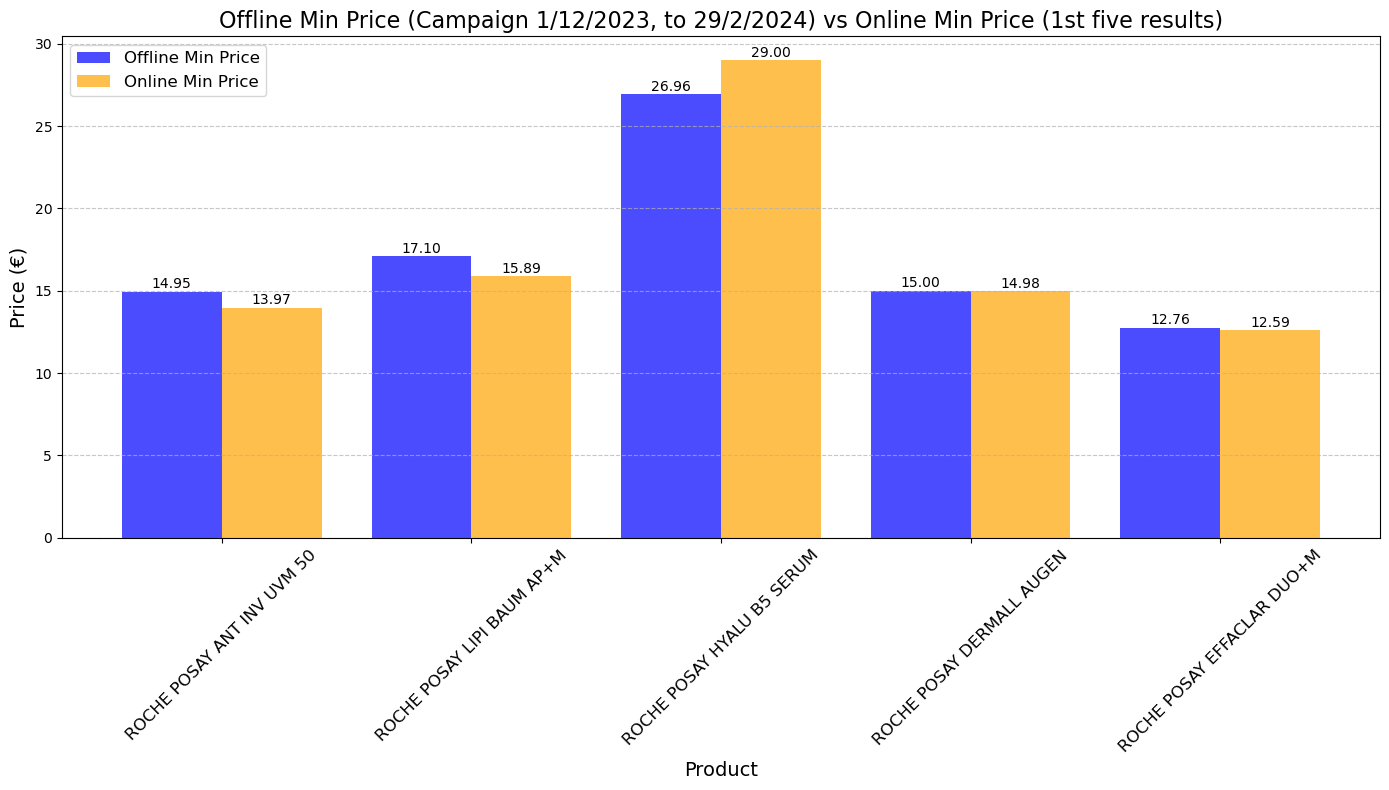

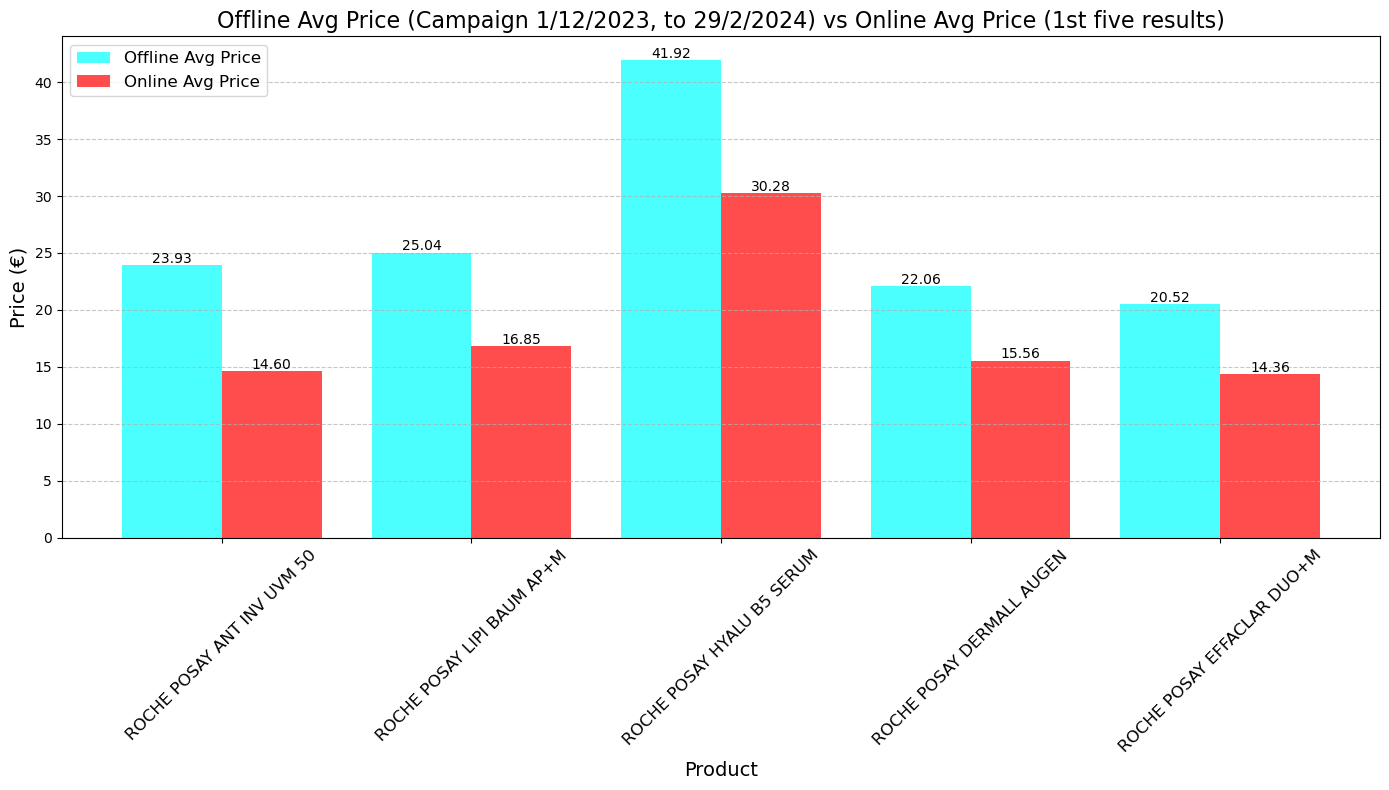

In [52]:
# Chart 1: Offline Min Price vs Online Min Price
plt.figure(figsize=(14, 8))
bar_width = 0.4
positions = range(len(result_df))

# Plot Offline Min Prices
offline_min_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Min Price'],
    width=bar_width,
    color='blue',
    alpha=0.7,
    label="Offline Min Price"
)

# Plot Online Min Prices
online_min_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Min Price'],
    width=bar_width,
    color='orange',
    alpha=0.7,
    label="Online Min Price"
)

# Add price labels to bars
for bar in offline_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_min_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Min Price (Campaign 1/12/2023, to 29/2/2024) vs Online Min Price (1st five results)", fontsize=16)
plt.xlabel("Product", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['name'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Chart 2: Offline Avg Price vs Online Avg Price
plt.figure(figsize=(14, 8))

# Plot Offline Avg Prices
offline_avg_bars = plt.bar(
    [p - bar_width / 2 for p in positions],
    result_df['Offline Avg Price'],
    width=bar_width,
    color='cyan',
    alpha=0.7,
    label="Offline Avg Price"
)

# Plot Online Avg Prices
online_avg_bars = plt.bar(
    [p + bar_width / 2 for p in positions],
    result_df['Online Avg Price'],
    width=bar_width,
    color='red',
    alpha=0.7,
    label="Online Avg Price"
)

# Add price labels to bars
for bar in offline_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)
for bar in online_avg_bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"{bar.get_height():.2f}", ha='center', fontsize=10)

# Add titles and labels
plt.title("Offline Avg Price (Campaign 1/12/2023, to 29/2/2024) vs Online Avg Price (1st five results)", fontsize=16)
plt.xlabel("Product", fontsize=14)
plt.ylabel("Price (€)", fontsize=14)
plt.xticks(positions, result_df['name'], rotation=45, fontsize=12)
plt.legend(loc="upper left", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()